<b>rBergomi Calibration Neural Network Approach</b>
<br>
<br>
<i>Plot function implementation from: https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning/tree/master </i>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi.rbergomi import rBergomi
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import helpers
from scipy.stats import truncnorm

import seaborn as sns

from tqdm import tqdm
tqdm.pandas()



import QuantLib as ql

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import sklearn.utils
import logging

import gc

from scipy.signal import savgol_filter

logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping
import tensorflow.experimental.numpy as tnp

%matplotlib inline

In [2]:
#not ordered
# ' [QUOTE_DATE]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]', ' [DTE]', 
# ' [C_GAMMA]', ' [C_VEGA]', ' [C_THETA]', ' [C_RHO]', ' [C_IV]',
# '<', ' [C_LAST]', ' [C_SIZE]', ' [C_BID]', ' [C_ASK]',
# ' [STRIKE]', ' [P_BID]', ' [P_ASK]', ' [P_LAST]', ' [P_DELTA]',
# ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]',
# ' [P_VOLUME]', ' [C_DELTA]'


def init():
    #load rfr
    rfr = pd.read_csv('C:\\Users\\caspa\\OneDrive\\Dokumente\\UNI\\THESIS\\code\\data\\USDLIBOR3M.csv', sep = ',', header = 0, index_col = 0, parse_dates = True, low_memory=False)

    dates = rfr.index
    percents = np.char.rstrip(rfr.values.astype(str), '%').astype(float) / 100
    return dates, percents

def load_month(year, month, source = 'SPX', clean = False):
    if month < 10:
        month = '0' + str(month)

    
    
    base_path = f'C:\\Users\\caspa\\OneDrive\\Dokumente\\UNI\\THESIS\\code\\data\\cleaned\\{source}'
    file_name = f'{source}_eod_{year}{month}.txt'
    file_path = os.path.join(base_path, file_name)

    if clean == False:
        base_path = f'C:\\Users\\caspa\\OneDrive\\Dokumente\\UNI\\THESIS\\code\\data\\cleaned\\{source}'
        file_name = f'{source}_eod_{year}{month}.txt'
        file_path = os.path.join(base_path, file_name)
        df = pd.read_csv(file_path, sep = ',', header = 0, index_col = 0, parse_dates = True, low_memory=False,usecols=[1,2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30])
    else:
        base_path = f'C:\\Users\\caspa\\OneDrive\\Dokumente\\UNI\\THESIS\\raw\\{source}'
        file_name = f'{source}_eod_{year}{month}.txt'
        file_path = os.path.join(base_path, file_name)
        df = pd.read_csv(file_path, sep = ',', header = 0, index_col = 0, parse_dates = True, low_memory=False)

    return df

def split_days(df, num_groups = 5):
    #number of different days in a group, set to 1 week 
    # Get unique values in specified column
    unique_vals = df[' [QUOTE_DATE]'].unique()
    
    # Split unique values into groups of specified size
    groups = [unique_vals[i:i + num_groups] for i in range(0, np.array(unique_vals).size, num_groups)]
    
    # Create a list of DataFrames, where each DataFrame consists of data from a specified number of unique values in
    # the specified column
    dataframes = []
    for group in groups:
        dataframes.append(df[df[' [QUOTE_DATE]'].isin(group)])
        
    return dataframes, np.array(groups).size

def detect_outliers(df, n, features):
    #detects outliers in a dataframe used to train the parameters of sabr model
    #n is the number of standard deviations away from the mean
    #features is the list of features to be checked for outliers
    #the function only filters for the feature implied volatility within same days to maturity and strike combinations

    #add feature that it also compares to close days to maturity and strike combinations
    print("")



def load_year(year, source = 'SPX', clean = False):
    df = pd.DataFrame()
    for month in range(1, 13):
        df = pd.concat([df, load_month(year, month, source, clean=clean)])
    return df

def load_index(idx, source = 'SPX', clean = False):
    month = idx % 12 + 1
    year = idx // 12 + 2010
    return load_month(year, month, source = source, clean = clean)

def get_IV_C(df):
    return df.iloc[1:,9]

def get_IV_P(df):
    return df.iloc[1:,24]

def get_strike(df):
    return df.iloc[1:,15]

def get_daystomaturity(df):
    #return the column with the days to maturity
    return df.iloc[1:,3]

def get_pricingdate(df):
    date = df.iloc[1,0]
    year = int(date[1:5])
    month = int(date[6:8])
    day = int(date[9:11])
    return year, month, day

def get_interestrate(year,month,date, dates, percents):
    #return the interest rate for the given date
    string = str(year) + '-' + str(month) + '-' + str(date)
    return float(percents[dates == string])
    #return float(np.exp(percents[dates == string]*yearfrac)-1)

def get_underlyinglast(df):
    return df.iloc[1,1]

def get_callprice(df):
    #returns mid price
    return (df.iloc[1:,8]+df.iloc[1:,9])/2

#test all functions and print first 6 rows  for the dataset
if __name__ == '__main__':
    dates,percents = init()

    #test rfr


def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2



In [3]:
def rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=60000):
    """Computes European Call price under rBergomi dynamics with MC sampling.
    #rgbergomi implementation of https://github.com/ryanmccrickerd/rough_bergomi
    Parameters:
    -----------
        H: Hurst parameter
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        tau: time to maturity in years (365 trading days per year)
        K: strike price
    """
    try:
        rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5)
        dW1, dW2 = rB.dW1(), rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho)
        xi = v0
        V = rB.V(Y, xi, eta)
        S = rB.S(V, dB)
        ST = S[:, -1]
        price = np.mean(np.maximum(ST-K, 0))
    except:
        return np.nan, np.nan
    
    # check numerical stability
    if price <= 0 or price + K < S0:
        iv = np.nan
        logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
    else:
        logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
        iv = implied_volatility(price, S0, K, tau, 0, 'c')
    gc.collect()
    return price, iv

In [4]:
#test pricing under rBergomi
rBergomi_pricer(H=0.4, eta=0.2, rho=-0.99, v0=5, tau=0.01, K=1.15, S0=1, MC_samples=60000)

(0.03123888359254462, 2.01853486195523)

In [5]:
#only used for input data, output is not rescaled 

class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [6]:
from tensorflow.keras import layers
#activation function: elu
def build_nn(input_length, hidden_layer_sizes=[30, 30, 30, 30]):
    model = tf.keras.Sequential()
    model.add(layers.Dense(units=hidden_layer_sizes[0], activation='elu', kernel_initializer='random_normal', 
                           input_shape=(input_length,)))
    for layer_idx in range(1, np.array(hidden_layer_sizes).size):
        model.add(layers.Dense(units=hidden_layer_sizes[layer_idx], activation='elu', kernel_initializer='random_normal'))
    #fully connected layer with linear activation at the end
    model.add(layers.Dense(units=1, activation='linear', kernel_initializer='random_normal'))
    return model


In [7]:
#verbose logging is partly disabled in tf v2.x
#high early stopping patience is used for deeper calibration

def train_nn(X_train, Y_train, X_val, Y_val, batch_size=128, n_epochs=50, hidden_layer_sizes=[30, 30, 30, 30], verbose=1):
    n_features = X_train.shape[1]
    model = build_nn(n_features, hidden_layer_sizes)
    
    print("Architecture for Neural Network:")
    model.summary()
    print('\n')
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=verbose, mode='auto', restore_best_weights=True)
    train_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                          validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, train_log.history
    #patience changed to 10 from 3


In [8]:
#todo move to helpers
def plot_learning_history(history):
    plt.figure()
    plt.plot(history['loss'], color='black', marker='o', label='train data loss')
    plt.plot(history['val_loss'], color='red', marker='o', label='val data loss')
    plt.xlabel("epochs")
    plt.ylabel('MSE loss')
    plt.legend(loc=1)
    plt.show()

In [9]:
K_T = pd.read_csv('data/rBergomi/labeled_data_all.csv')
#random shuffle K_T
K_T = K_T.sample(frac=1).reset_index(drop=True)
alldata = K_T.copy()


train = alldata.iloc[:int(alldata.shape[0]*0.8), :]
val = alldata.iloc[int(alldata.shape[0]*0.8):int(alldata.shape[0]*0.9), :]
test = alldata.iloc[int(alldata.shape[0]*0.9):, :]
K_T.head()

Moneyness  Time to Maturity (years)         H       eta       rho  \
0   0.990799                  0.115079  0.147931  1.320786 -0.689152   
1   0.990799                  0.198413  0.139146  1.062972 -0.595863   
2   0.977885                  0.031746  0.027782  3.548907 -0.844387   
3   0.956755                  0.059524  0.129158  2.847673 -0.513420   
4   0.914493                  0.067460  0.090904  2.213148 -0.773121   

         v0        iv  
0  3.146769  1.613185  
1  0.208201  0.440379  
2  0.051902  0.165204  
3  1.050236  0.866190  
4  0.107963  0.361752

In [10]:
K_T.shape

(1112371, 7)

In [11]:
train.shape, val.shape, test.shape

((889896, 7), (111237, 7), (111238, 7))

In [12]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [13]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [14]:
X_train.shape, Y_train.shape

((889896, 6), (889896, 1))

In [15]:
# parameters
hidden_layer_sizes = [30, 30, 40, 30]
batch_size = 128
n_epochs = 250 #50

In [17]:
#scaled data used for training
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Architecture for Neural Network:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                210       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 40)                1240      
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,641
Trainable params: 3,641
Non-trainable params: 0
_________________________________________________________________


Epoch 1/250
27810/2

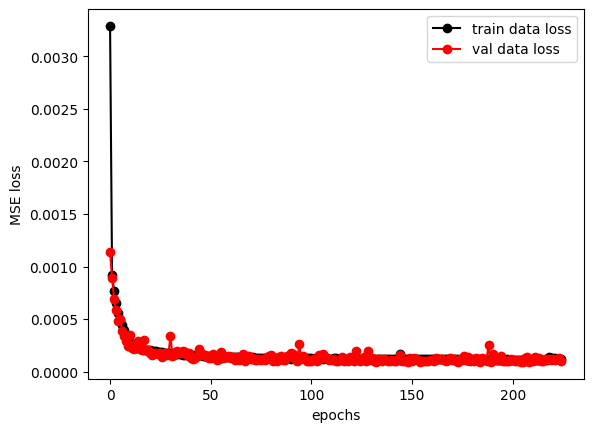

In [27]:
plot_learning_history(history)

In [18]:
# model.evaluate(X_test, Y_test)
model.evaluate(X_test, Y_test)

3477/3477 [==============================] - 8s 2ms/step - loss: 1.0127e-04


0.00010127008863491938

In [16]:
model.save("testFINALBergomi.h5")

In [16]:
#load model parameters
model = tf.keras.models.load_model("FINALBergomi.h5")

In [17]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

3477/3477 [==============================] - 14s 4ms/step


In [18]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*np.array(relative_error).size)]
q_95 = sorted_re[int(0.95*np.array(relative_error).size)]
q_99 = sorted_re[int(0.99*np.array(relative_error).size)]

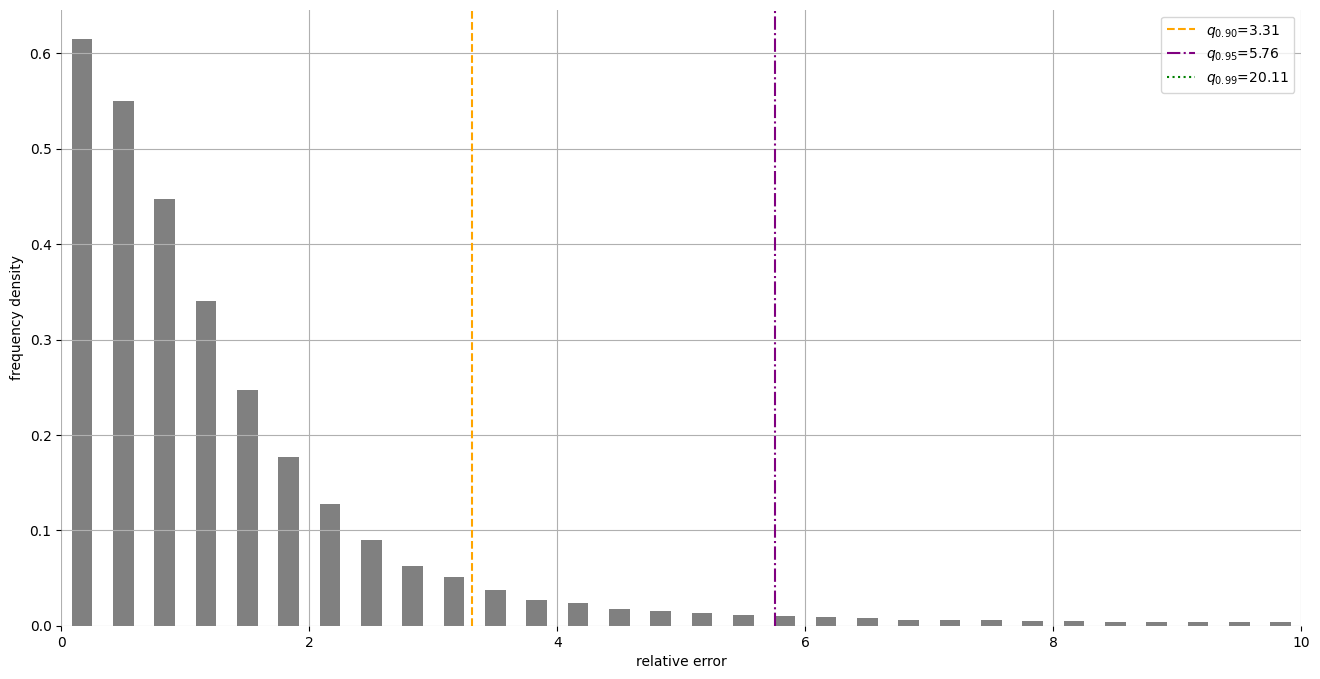

In [87]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 50, 151), density=True, rwidth=0.5, color='grey')
plt.xlim((0, 10))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

In [88]:
log_moneyness = np.linspace(-0.15, 0.15, 30)
maturity = np.linspace(0.01, 1, 30)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'H', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['H'] = 0.05
df['eta'] = 2.3
df['rho'] = -0.98
df['v0'] = 0.03

In [89]:
df.head()

Moneyness  Time to Maturity (years)     H  eta   rho    v0   iv
0   0.860708                      0.01  0.05  2.3 -0.98  0.03  NaN
1   0.869658                      0.01  0.05  2.3 -0.98  0.03  NaN
2   0.878701                      0.01  0.05  2.3 -0.98  0.03  NaN
3   0.887838                      0.01  0.05  2.3 -0.98  0.03  NaN
4   0.897071                      0.01  0.05  2.3 -0.98  0.03  NaN

In [90]:
df['iv'] = 1 #dummy

In [19]:
#calculate the MC implied surface given the parameters
df['iv'] = df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
                                                          row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
                             axis=1)

NameError: name 'df' is not defined

In [91]:
scaled_features = SCALER.transform(df.iloc[:, :-1])
df['iv_nn'] = model.predict(scaled_features)

29/29 [==============================] - 0s 3ms/step


In [92]:
df['Log Moneyness'] = log_moneyness.flatten()
df['relative_error'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [93]:
df.dropna(inplace=True)

In [ ]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values)
    plt.show()

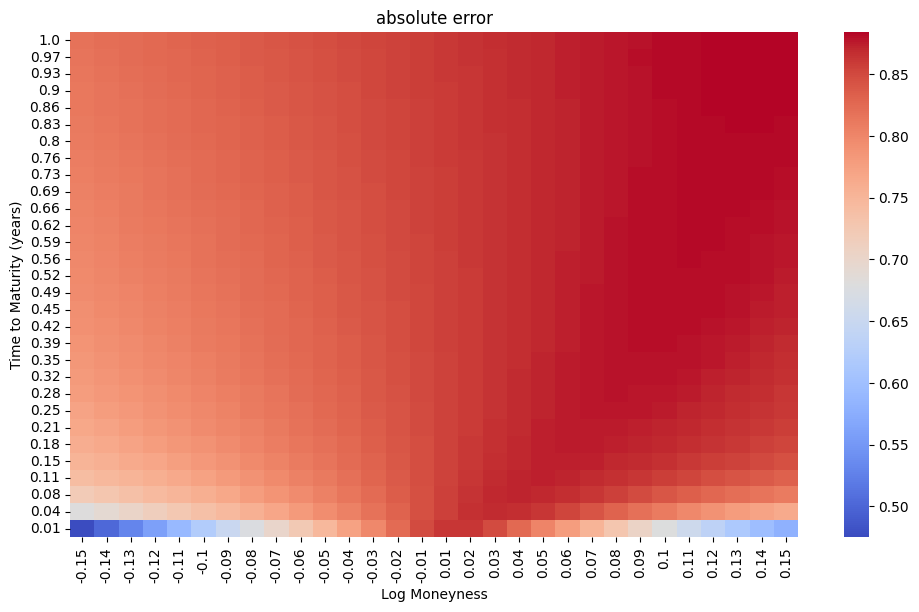

KeyError: 'relative error'

In [95]:
df['absolute error'] = np.abs(df['iv_nn'] - df['iv'])
plot_heatmap(df, 'absolute error')
plot_heatmap(df, 'relative error')

<b>Visualize Error on test set </b>

In [96]:
#make df with columns ['relative_error', 'absolute_error', 'Moneyness', 'Time to Maturity (years)', 'Log Moneyness']
vis = pd.DataFrame(columns=['relative_error', 'absolute_error', 'Moneyness', 'Time to Maturity (years)', 'Log Moneyness'])

In [820]:
predictiontraining = model.predict(X_train).flatten()
truetraining = Y_train.values.flatten()
relative_error_training = np.abs(predictiontraining - truetraining) / truetraining
absolute_error_training = np.abs(predictiontraining - truetraining)
vis = pd.DataFrame(columns=['relative_error', 'absolute_error', 'Moneyness', 'Time to Maturity (years)', 'Log Moneyness'])
vis['relative_error'] = relative_error_training
vis['absolute_error'] = absolute_error_training
vis['Moneyness'] = X_train_origin['Moneyness']
vis['Time to Maturity (years)'] = X_train_origin['Time to Maturity (years)']
vis['Log Moneyness'] = np.log(X_train_origin['Moneyness'])
vis_pivot = vis.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values='relative_error', aggfunc='mean')
vis_df = vis_pivot.stack().reset_index()
vis_df.columns = ['Time to Maturity (years)', 'Log Moneyness', 'relative_error']
vis['Log Moneyness'] = np.round(vis['Log Moneyness']/0.03)*0.03
vis['Time to Maturity (years)'] = np.round(vis['Time to Maturity (years)']/0.03)*0.03

27810/27810 [==============================] - 40s 1ms/step


In [ ]:
def plot_heatmap(data, values='re'):            #adjusted heatmap for paper plots
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values, fontsize=22)
    plt.xlabel('Log Moneyness', fontsize=22)
    plt.ylabel('Time to Maturity (years)', fontsize=22)
    # Adjust x-axis tick labels
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize=22)


    plt.yticks(fontsize=13)
    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)


    plt.show()

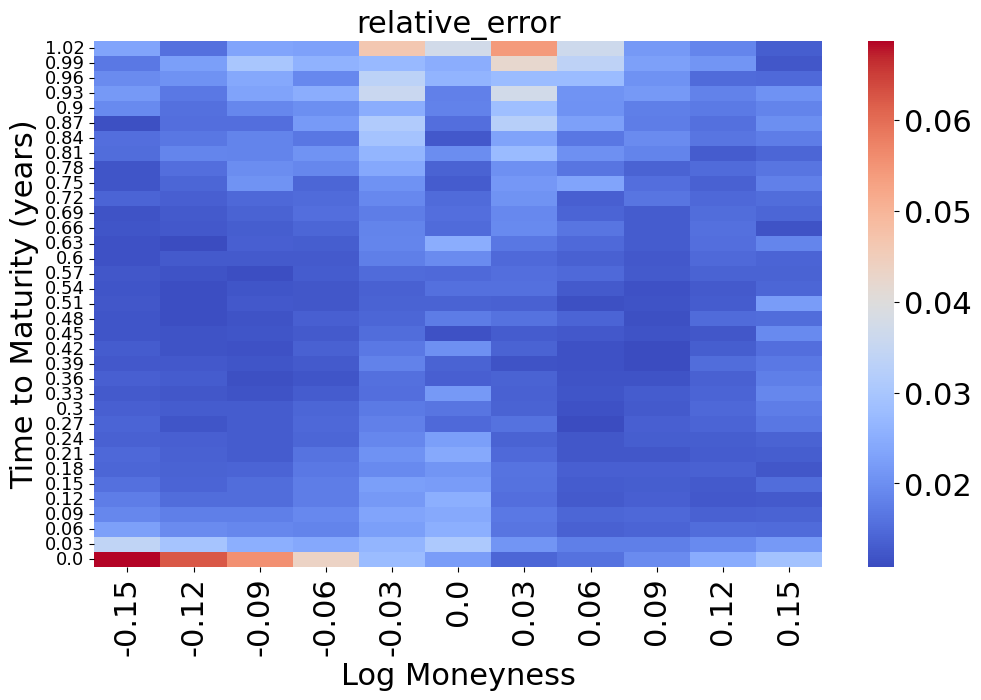

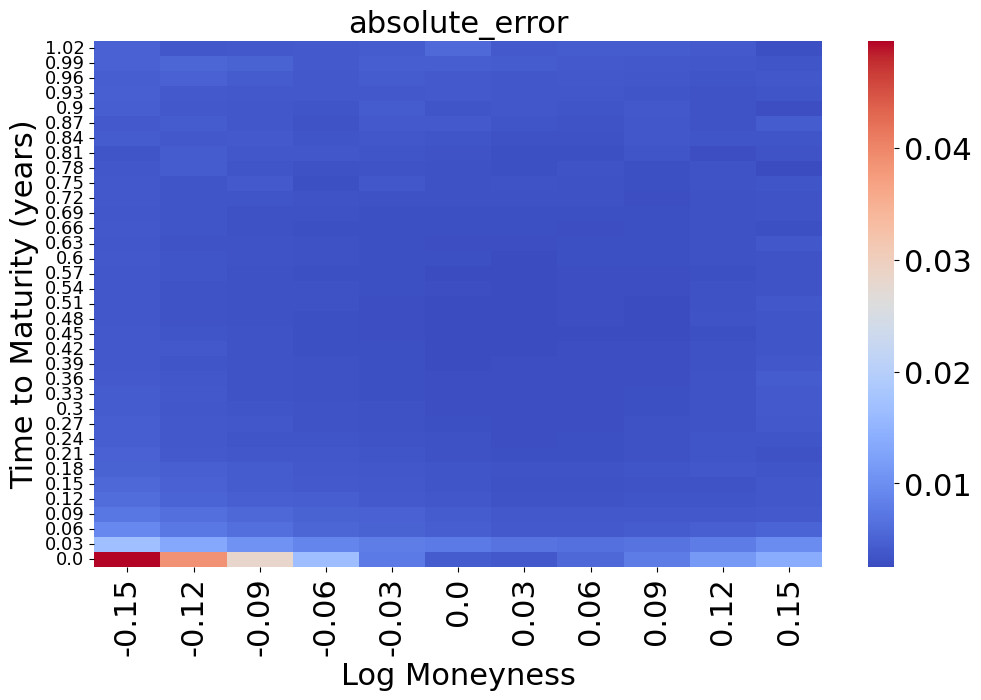

In [845]:
plot_heatmap(vis, 'relative_error')
plot_heatmap(vis, 'absolute_error')

In [ ]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = 'coolwarm')#plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

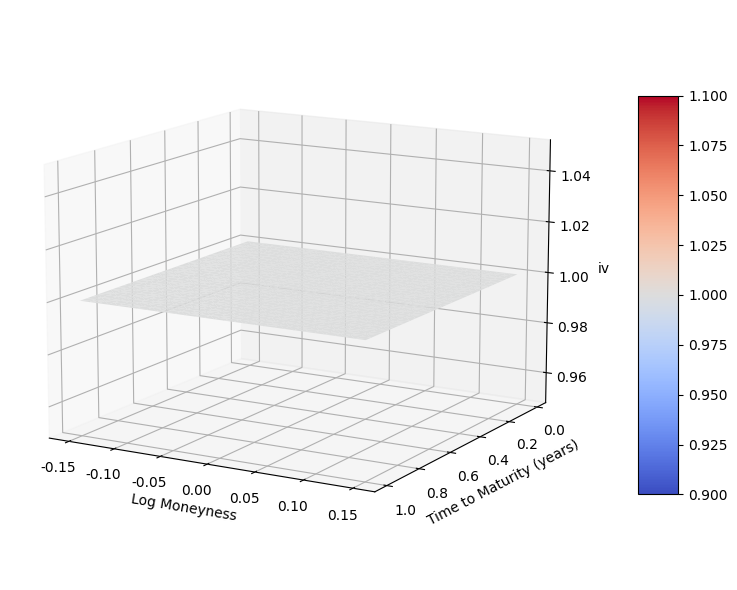

In [68]:
plot_iv_surface(df, z='iv')

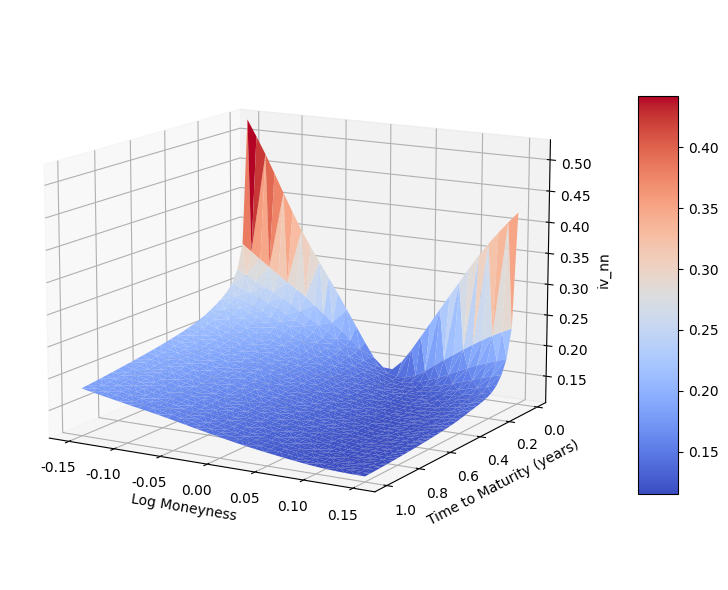

In [69]:
plot_iv_surface(df, z='iv_nn')

In [19]:
from utils import heston_pricer, rBergomi_pricer

In [21]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # lambda
            np.random.rand(), # vbar
            5 * np.random.rand(), # eta
            -1 * np.random.rand(), # rho
            np.random.rand() #v0
        ]
        names = ['lambda', 'vbar', 'eta', 'rho', 'v0']
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # eta
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1)**2 # v0
        ]
        names = ['H', 'eta', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names

In [23]:
#different imppelemtations of the jacobian matrix
def jacobian_LM(params):
    # Extract the estimated parameters from the input vector
    
    H, eta, rho, v0 = params

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0

    #convert to tensor
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the inputs to calculate the gradients
        tape.watch(inputs)
        
        # Use the trained neural network model to predict implied volatility
        predicted_vola = model(inputs)
    
    # Calculate the gradients of the predicted implied volatility with respect to the parameters
    gradients = tape.gradient(predicted_vola, inputs)
    
    # Extract the gradients of the estimated parameters
    dH, deta, drho, dv0 = tf.unstack(gradients[:, 2:], axis=1)
    
    # Return the Jacobian matrix with dimensions Nx4
    return np.array(tf.stack([dH, deta, drho, dv0], axis=1))


from scipy.optimize import approx_fprime

def numeric_jacobian(params):
    
    grad_approx = approx_fprime(params, predict_nn, epsilon=1e-4)
    return grad_approx
    
def jacobian_LM_batch(params):
    # Extract the estimated parameters from the input vector
    
    H, eta, rho, v0 = params

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0

    # #scale data
    # inputs = SCALER.transform(inputs)


    #convert to tensor
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the inputs to calculate the gradients
        tape.watch(inputs)
        
        # Use the trained neural network model to predict implied volatility
        predicted_vola = model(inputs)
    
    batch_jacobian = tape.batch_jacobian(predicted_vola, inputs)
    #reshape tf batch
    batch_jacobian = tf.reshape(batch_jacobian, (batch_jacobian.shape[0], batch_jacobian.shape[2]))    


    dH, deta, drho, dv0 = tf.unstack(batch_jacobian[:, 2:], axis=1)
    
    # Return the Jacobian matrix with dimensions Nx4
    return np.array(tf.stack([dH, deta, drho, dv0], axis=1))


In [24]:
#used for nelder mead
def predict_nn(params):
    # Unpack the parameters
    H, eta, rho, v0 = params

    # Check if the parameters exceed the bounds
    if any(param < lower_bound or param > upper_bound for param, lower_bound, upper_bound in zip(params, lower_bounds, upper_bounds)):
        # Return a high cost if any parameter is outside the bounds
        return 1e10  # Adjust the penalty value as needed

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0
    # Make predictions using the neural network model
    predictions = model.predict(inputs)

    # Calculate the mean squared error (MSE) between predictions and targets
    #mse = np.mean(np.square(predictions - actual_vola))

    return predictions.flatten()

In [25]:
# Define the cost function for nelder mead
def cost_function(params):
    # Unpack the parameters
    H, eta, rho, v0 = params

    # Check if the parameters exceed the bounds
    if any(param < lower_bound or param > upper_bound for param, lower_bound, upper_bound in zip(params, lower_bounds, upper_bounds)):
        # Return a high cost if any parameter is outside the bounds
        return 1e10  # Adjust the penalty value as needed

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0
    # Make predictions using the neural network model
    predictions = model.predict(inputs)

    # Calculate the mean squared error (MSE) between predictions and targets
    mse = np.mean(np.square(predictions - actual_vola))

    return mse #returns 1 value


# cost function for Levenberg-Marquardt, can be used in a Scipy optimizer
def cost_function_LM(params):
    # Unpack the parameters
    H, eta, rho, v0 = params

    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0
    # Make predictions using the neural network model
    predictions = model.predict(inputs)

    # Calculate the mean squared error (MSE) between predictions and targets
    se = np.mean(np.square(predictions - actual_vola), axis=0)

    return se   #returns array of shape (n,1)

def loss_function(params):
    H, eta, rho, v0 = params
    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0
    
    # Use the trained neural network model to predict implied volatility

    #scale data
    scaled = SCALER.transform(inputs)
    predicted_vola = model.predict(scaled)
    # Calculate the difference between the predicted and actual implied volatility
    loss = predicted_vola - actual_vola.reshape(-1, 1)      #returns array of shape (n,1)
    return loss

In [26]:
#these are the bounds in the initial space
lower_bounds = [0, 0.1, -1, 0.0025]  # Lower bounds for H, eta, rho, v0
upper_bounds = [0.5, 4.5, 0, 2]   # Upper bounds for H, eta, rho, v0


#these are the bounds in the scaled space where the optimization is performed
dummy = pd.DataFrame()
dummy['Moneyness'] = np.array([0,0])
dummy['Time to Maturity (years)'] = np.array([0,0])
dummy['H'] = np.array([lower_bounds[0], upper_bounds[0]])
dummy['eta'] = np.array([lower_bounds[1], upper_bounds[1]])
dummy['rho'] = np.array([lower_bounds[2], upper_bounds[2]])
dummy['v0'] = np.array([lower_bounds[3], upper_bounds[3]])
dummy_scaled = SCALER.transform(dummy)
lower_bounds = dummy_scaled.iloc[0, 2:]
upper_bounds = dummy_scaled.iloc[1, 2:]
bounds = (lower_bounds, upper_bounds)
bounds

(H     -2.043771
 eta   -2.843403
 rho   -1.534444
 v0    -0.741776
 Name: 0, dtype: float64,
 H      5.869006
 eta    3.058696
 rho    5.202123
 v0     3.283094
 Name: 1, dtype: float64)

In [104]:
df.head()

Moneyness  Time to Maturity (years)     H  eta   rho    v0  iv     iv_nn  \
0   0.860708                      0.01  0.05  2.3 -0.98  0.03   1  0.524827   
1   0.869658                      0.01  0.05  2.3 -0.98  0.03   1  0.498140   
2   0.878701                      0.01  0.05  2.3 -0.98  0.03   1  0.470299   
3   0.887838                      0.01  0.05  2.3 -0.98  0.03   1  0.440204   
4   0.897071                      0.01  0.05  2.3 -0.98  0.03   1  0.409089   

   Log Moneyness  relative_error  absolute error  
0      -0.150000        0.475173        0.475173  
1      -0.139655        0.501860        0.501860  
2      -0.129310        0.529701        0.529701  
3      -0.118966        0.559796        0.559796  
4      -0.108621        0.590911        0.590911

In [105]:
initial_params = model_parameters_initializer('rBergomi')[0]
# parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later

#test given the sample generated above to test the NN
data = pd.DataFrame()
data['Moneyness'] = df['Moneyness'].values
data['Time to Maturity (years)'] = df['Time to Maturity (years)'].values
#dummy to rescale, not used
data['H'] = initial_params[0]
data['eta'] = initial_params[1]
data['rho'] = initial_params[2]
data['v0'] = initial_params[3]
datascaled = SCALER.transform(data)
moneyness = datascaled.iloc[:, 0]
time_to_maturity = datascaled.iloc[:, 1]
initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
#calibrate to reach this vola
actual_vola = df['iv_nn'].values                    #we try to retrieve the parameters we used to generate the surface in df

In [106]:
#test jacobian
print(jacobian_LM_batch(initial_params).shape)          #fast
print(jacobian_LM(initial_params).shape)                #fast
print(numeric_jacobian(initial_params).shape)           #slow
#test cost function
print(cost_function_LM(initial_params).shape)           

(900, 4)
(900, 4)
29/29 [==============================] - 0s 3ms/step
(900, 4)
29/29 [==============================] - 0s 4ms/step
(900,)


In [118]:
#scipy Levenberg-Marquardt, gives bad results
import scipy.optimize
resultLM = scipy.optimize.least_squares(
    cost_function_LM,
    initial_params,
    jacobian_LM,
    bounds=bounds,
    gtol=1E-9
)

29/29 [==============================] - 0s 2ms/step


In [119]:
print(resultLM.cost)            #5.4% mse, 5.3 seconds
resultLM

0.03334324061870575


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.132e-01  9.615e-02 ...  7.565e-03  7.575e-03]
           x: [-1.310e+00  9.607e-02 -5.893e-01 -6.615e-01]
        cost: 0.03334324061870575
         jac: [[ 3.266e-03  6.415e-03  3.694e-03  5.358e-01]
               [-1.510e-03  1.297e-02  2.783e-03  5.867e-01]
               ...
               [-4.388e-02 -5.918e-03  9.761e-03  9.552e-01]
               [-4.365e-02 -3.891e-03  1.050e-02  9.358e-01]]
        grad: [-1.150e-01 -8.406e-03  2.122e-02  4.243e+00]
  optimality: 0.8258325739252803
 active_mask: [0 0 0 0]
        nfev: 13
        njev: 1

29/29 [==============================] - 0s 3ms/step
Mean relative error: 0.20483285188674927
Mean absolute error: 0.030276397243142128


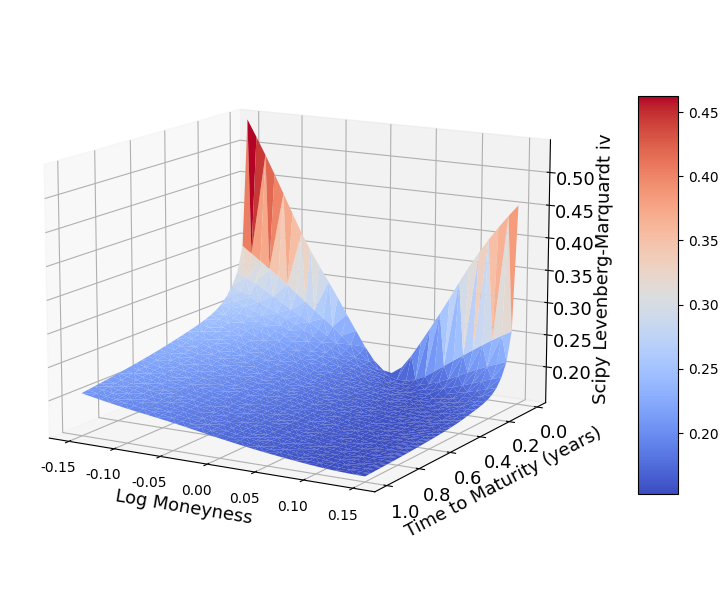

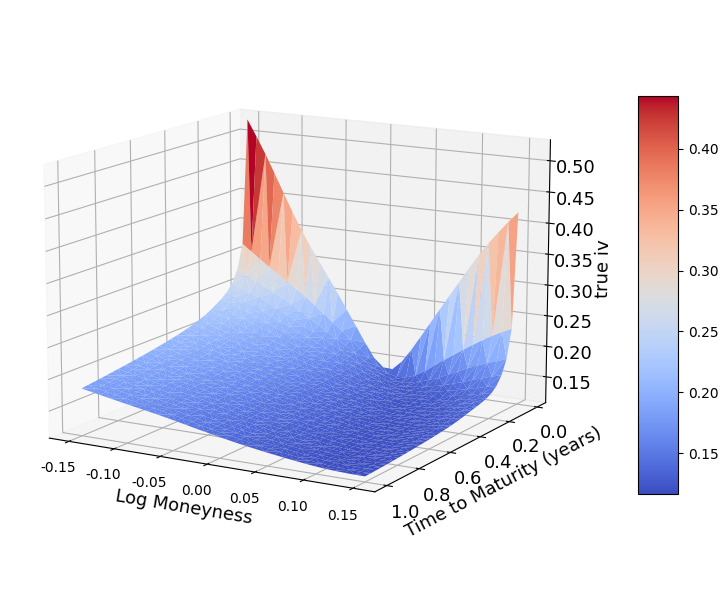

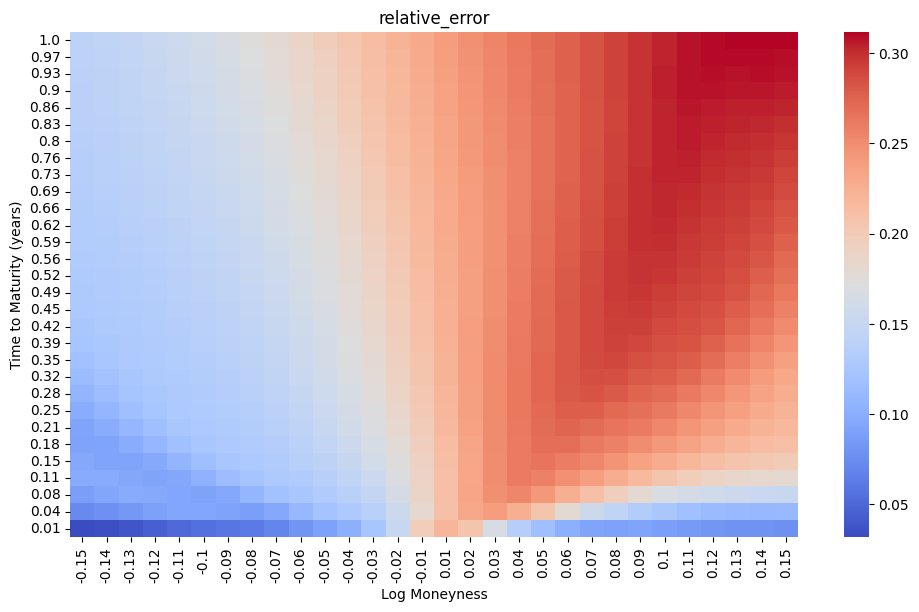

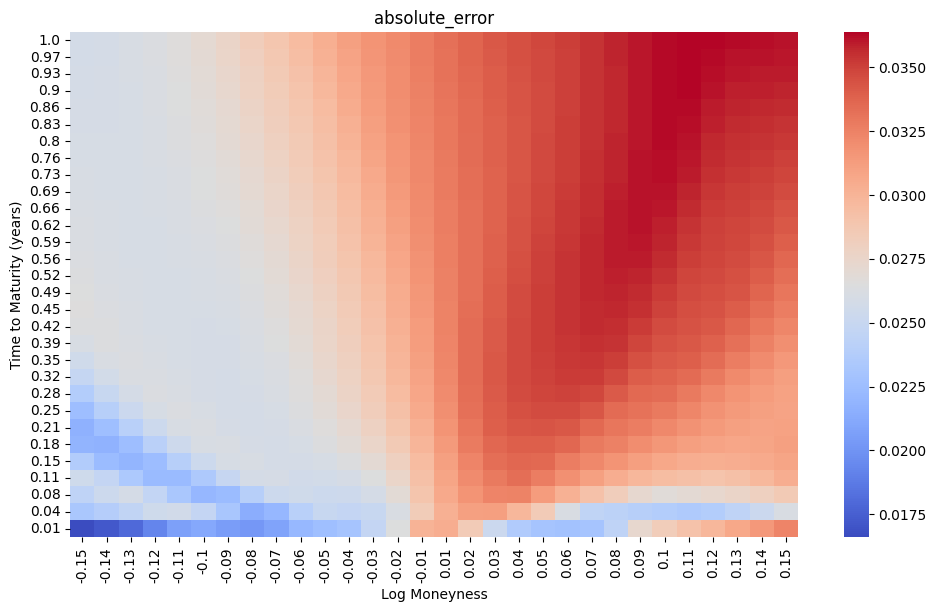

In [130]:
dfres = pd.DataFrame()
dfres['Moneyness'] = moneyness
dfres['Time to Maturity (years)'] = time_to_maturity
dfres['H'] = resultLM.x[0]
dfres['eta'] = resultLM.x[1]
dfres['rho'] = resultLM.x[2]
dfres['v0'] = resultLM.x[3]
pred_iv = model.predict(dfres)
dfres = SCALER.inverse_transform(dfres)
dfres['Scipy Levenberg-Marquardt iv'] = pred_iv
dfres['true iv'] = actual_vola
dfres['relative_error'] = np.abs(dfres['Scipy Levenberg-Marquardt iv'] - dfres['true iv']) / dfres['true iv']
dfres['Log Moneyness'] = np.log(dfres['Moneyness'])


dfres['absolute_error'] = np.abs(dfres['Scipy Levenberg-Marquardt iv'] - dfres['true iv'])
print("Mean relative error: {}".format(np.mean(dfres['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres['absolute_error'])))
plot_iv_surface_play(dfres, z='Scipy Levenberg-Marquardt iv')
plot_iv_surface_play(dfres, z='true iv')
plot_heatmap(dfres, 'relative_error')
plot_heatmap(dfres, 'absolute_error')

In [132]:
rmse = np.sqrt(np.mean(np.square(dfres['Scipy Levenberg-Marquardt iv'] - dfres['true iv'])))
rmse

0.030560061

In [145]:
#gradient free optimization, nelder mead, gives good results but slow
from scipy import optimize as opt
#max iter = N*200 = 800 per default
result_NM = opt.minimize(cost_function, initial_params, method='nelder-mead', options={'fatol': 1e-10, 'disp': True})

29/29 [==============================] - 0s 2ms/step
Optimization terminated successfully.
         Current function value: 0.003614
         Iterations: 186
         Function evaluations: 358


In [146]:
print(result_NM.fun)            #0.269% mse, 86.5 seconds
result_NM

0.0036137523129582405


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0036137523129582405
             x: [-2.010e+00 -2.024e-01 -1.535e+00 -6.975e-01]
           nit: 186
          nfev: 358
 final_simplex: (array([[-2.010e+00, -2.024e-01, -1.535e+00, -6.975e-01],
                       [-2.010e+00, -2.024e-01, -1.535e+00, -6.975e-01],
                       ...,
                       [-2.010e+00, -2.024e-01, -1.535e+00, -6.975e-01],
                       [-2.010e+00, -2.024e-01, -1.535e+00, -6.975e-01]]), array([ 3.614e-03,  3.614e-03,  3.614e-03,  3.614e-03,
                        3.614e-03]))

29/29 [==============================] - 0s 2ms/step
Mean relative error: 0.10811254382133484
Mean absolute error: 0.016673630103468895


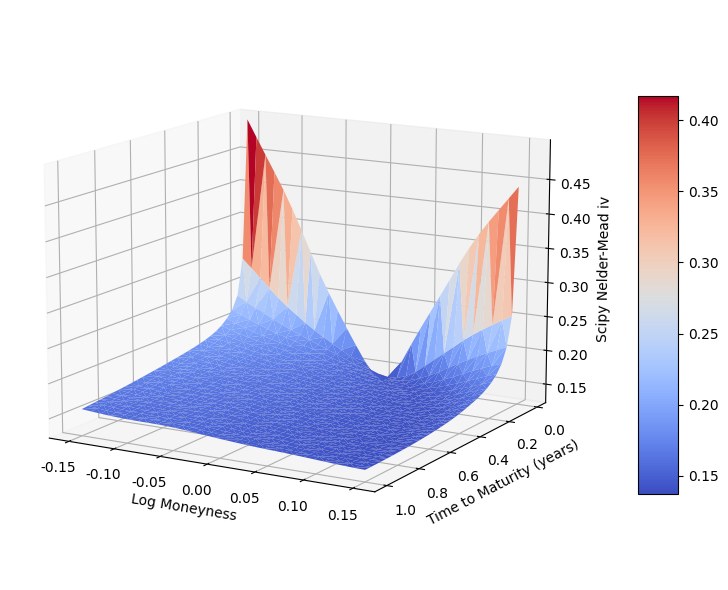

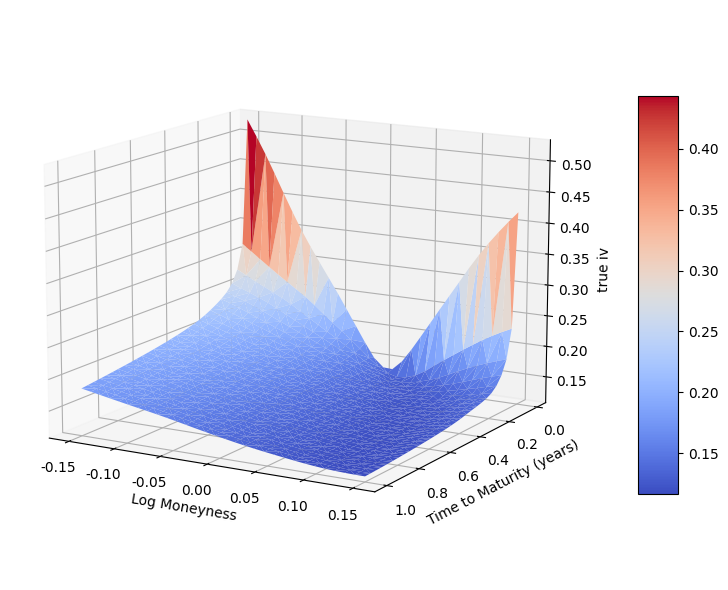

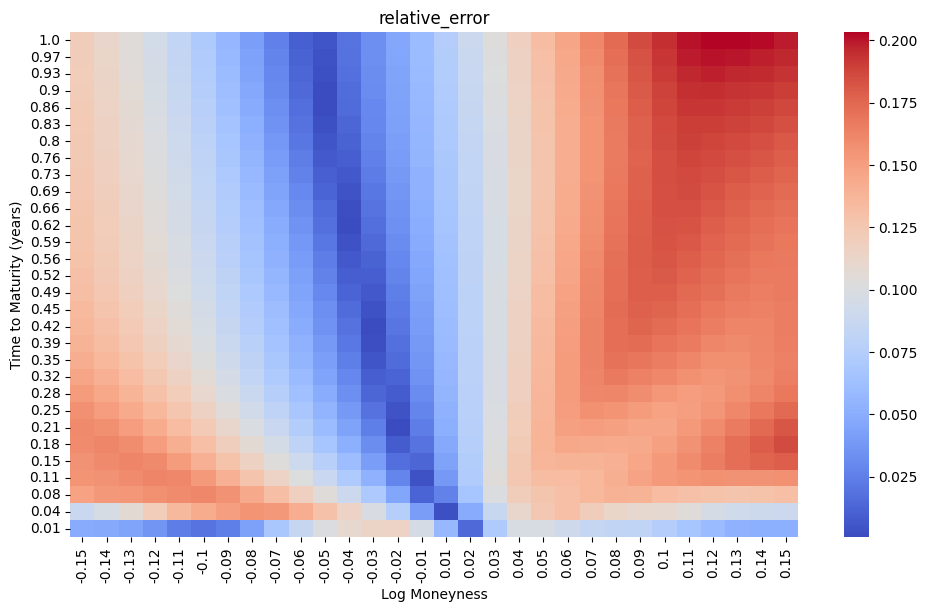

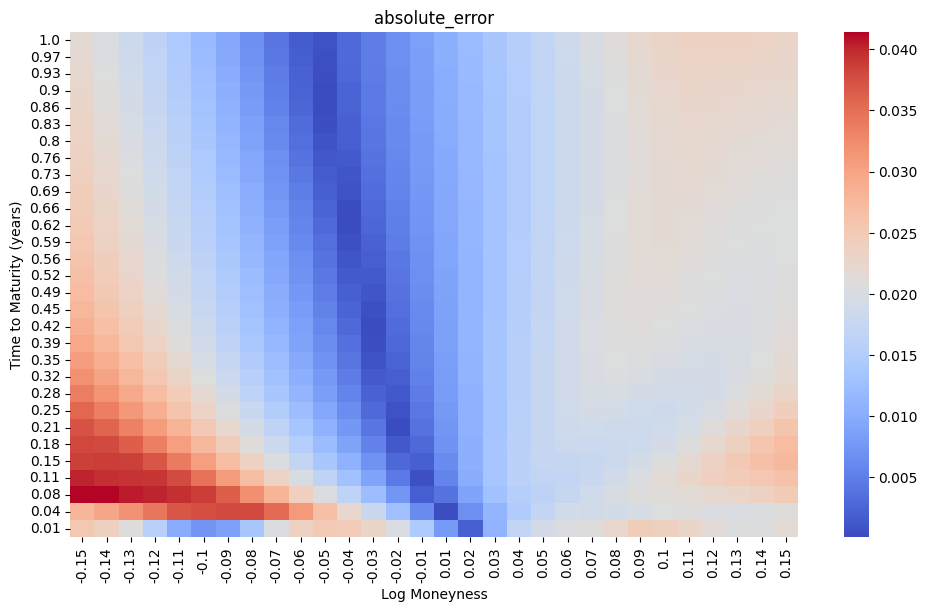

In [147]:
dfres = pd.DataFrame()
dfres['Moneyness'] = moneyness
dfres['Time to Maturity (years)'] = time_to_maturity
dfres['H'] = result_NM.x[0]
dfres['eta'] = result_NM.x[1]
dfres['rho'] = result_NM.x[2]
dfres['v0'] = result_NM.x[3]
pred_iv = model.predict(dfres)
dfres = SCALER.inverse_transform(dfres)
dfres['Scipy Nelder-Mead iv'] = pred_iv
dfres['true iv'] = actual_vola
dfres['relative_error'] = np.abs(dfres['Scipy Nelder-Mead iv'] - dfres['true iv']) / dfres['true iv']
dfres['Log Moneyness'] = np.log(dfres['Moneyness'])

dfres['absolute_error'] = np.abs(dfres['Scipy Nelder-Mead iv'] - dfres['true iv'])
print("Mean relative error: {}".format(np.mean(dfres['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres['absolute_error'])))
plot_iv_surface(dfres, z='Scipy Nelder-Mead iv')
plot_iv_surface(dfres, z='true iv')
plot_heatmap(dfres, 'relative_error')
plot_heatmap(dfres, 'absolute_error')

In [148]:
rmse = np.sqrt(np.mean(np.square(dfres['Scipy Nelder-Mead iv'] - dfres['true iv'])))
rmse

0.018615887

In [27]:
#custom Levenberg-Marquardt, gives good results
#regularization is used to stabilize the matrix inversion
#learning rate is increased or decreased depending on the loss
#the loss is calculated as the sum of the absolute error
#rmse is added even if not used as loss metric to be comparable to other literature
def manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75):

    params = initial_params

    n_samples = moneyness.shape[0]
    n_params = np.array(initial_params).size #=5
    #identity matrix for stability as regularizer
    I = np.eye(n_params)    #5x5
    Q = actual_vola.reshape((-1, 1)) # shape: [n_samples, 1]


    iteration = 0  # Initialize iteration count

    H, eta, rho, v0 = initial_params
    #make a df
    inputs = pd.DataFrame()
    inputs['Moneyness'] = moneyness
    inputs['Time to Maturity (years)'] = time_to_maturity
    inputs['H'] = H
    inputs['eta'] = eta
    inputs['rho'] = rho
    inputs['v0'] = v0

    prediction = model.predict(inputs)
    jac = jacobian_LM(initial_params) #Nx5
    R = prediction - Q #absolute error Nx1
    A0 = jac.T.dot(jac) #5x5
    A = np.linalg.pinv(A0 + learning_rate * I) #5x5
    B = jac.T.dot(R) #5x1
    delta_params = A.dot(B).flatten() #5x1


    while iteration < max_iterations and np.linalg.norm(delta_params) > tolerance:
        if iteration % 2 == 0:
        #Print the loss every 10 terations
            print("Iteration: {0}, Loss: {1}".format(iteration, np.sum(abs(R))))

        params_new = params - delta_params
        inputs['H'] = params_new[0]
        inputs['eta'] = params_new[1]
        inputs['rho'] = params_new[2]
        inputs['v0'] = params_new[3]

        prediction = model.predict(inputs)
        jac_new = jacobian_LM(params_new) #Nx5
        R_new = prediction - Q #absolute error Nx1
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - jac.dot(delta_params)))

        if c_mu <= LR_lower:
            #increase learning rate
            learning_rate *= 2
            params = params_new
            R = R_new
            jac = jac_new
            print("Learning rate increased to {}".format(learning_rate))
        else:
            params = params_new
            R = R_new
            jac = jac_new
        if c_mu >=LR_upper:
            learning_rate /= 2.0
            print("Learning rate decreased to {}".format(learning_rate))
            #reduce learning rate
        A0 = jac.T.dot(jac) #5x5
        A = np.linalg.pinv(A0 + learning_rate * I) #5x5
        B = jac.T.dot(R) #5x1
        delta_params = A.dot(B).flatten() #5x1

        iteration += 1  # Increment iteration count

    if iteration < max_iterations:
        print("Leave iterations early after {} iters".format(iteration))

    rmse = np.sqrt(np.mean(np.square(prediction - Q), axis = None))
    print("FINAL RMSE: {}".format(rmse))
    mse = np.mean(np.square(prediction - Q), axis = None)
    mae = np.mean(np.abs(prediction - Q), axis = None)
    median_se = np.median(np.square(prediction - Q), axis = None)

    return params, rmse, mse, mae, median_se

In [139]:
result_manual = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)

29/29 [==============================] - 0s 2ms/step
Iteration: 0, Loss: 27.24875831604004
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 1.6758177280426025
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 1.3958752155303955
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 1.33908212184906
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 1.3254766464233398
29/29 [==============================] - 0s 2ms/step
Learning rate increased to 

In [143]:
result_manual = result_manual[0]

29/29 [==============================] - 0s 3ms/step
Mean relative error: 0.009747042320668697
Mean absolute error: 0.0014677749713882804


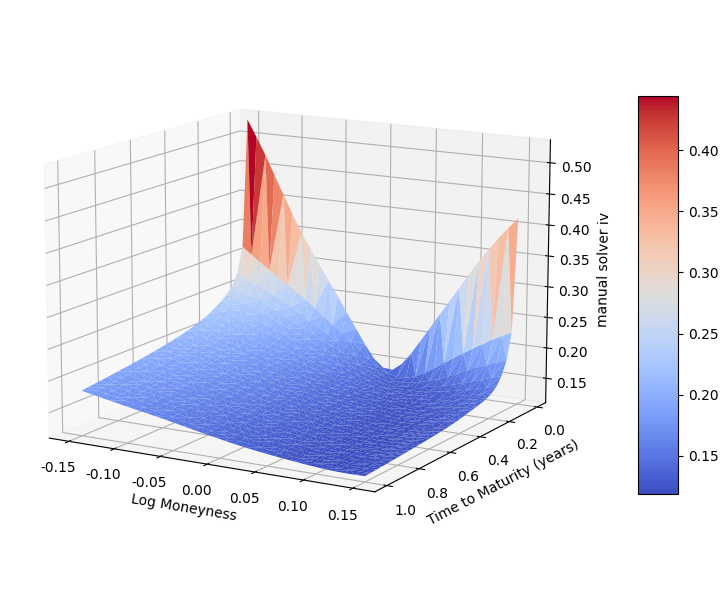

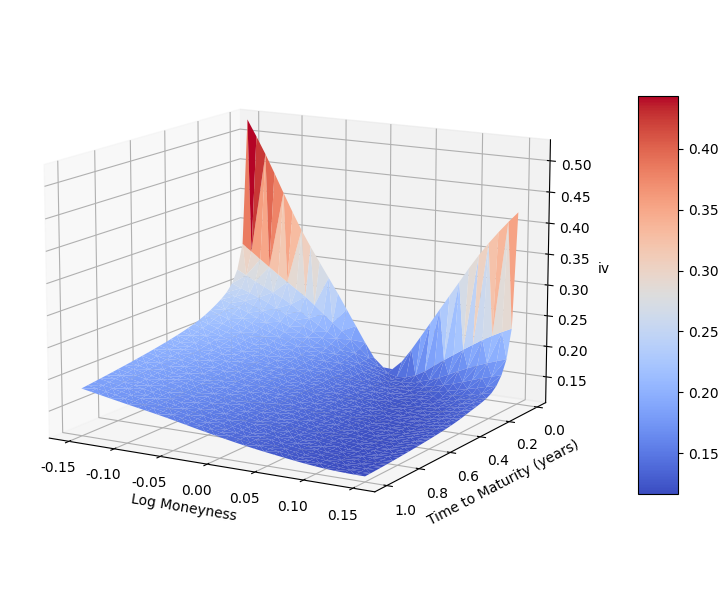

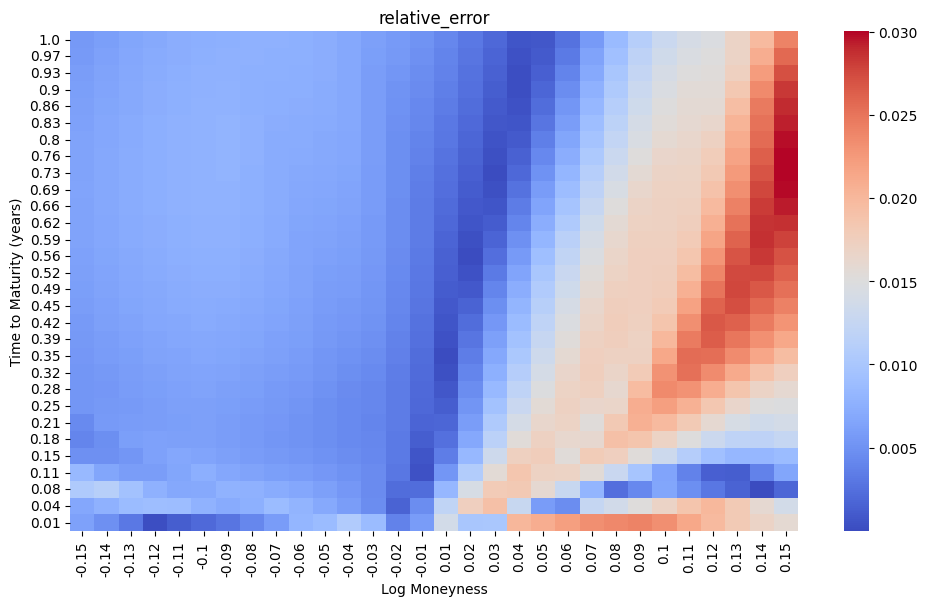

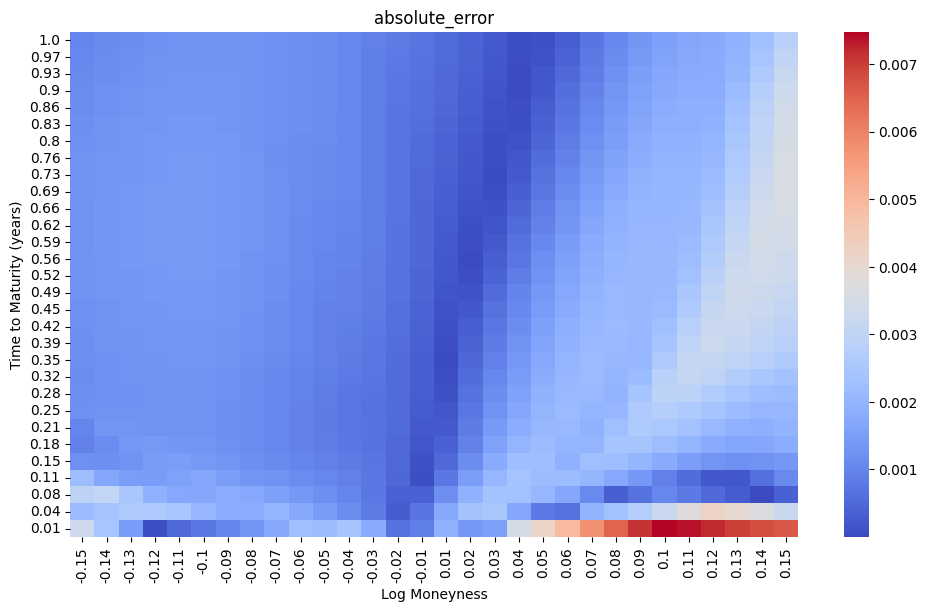

In [144]:
dfres_manual = pd.DataFrame()
dfres_manual['Moneyness'] = moneyness
dfres_manual['Time to Maturity (years)'] = time_to_maturity
dfres_manual['H'] = result_manual[0]
dfres_manual['eta'] = result_manual[1]
dfres_manual['rho'] = result_manual[2]
dfres_manual['v0'] = result_manual[3]
pred_iv = model.predict(dfres_manual)
dfres_manual = SCALER.inverse_transform(dfres_manual)
dfres_manual['manual solver iv'] = pred_iv
dfres_manual['iv'] = actual_vola
dfres_manual['relative_error'] = np.abs(dfres_manual['manual solver iv'] - dfres_manual['iv']) / dfres_manual['iv']
dfres_manual['Log Moneyness'] = np.log(dfres_manual['Moneyness'])
dfres_manual['absolute_error'] = np.abs(dfres_manual['manual solver iv'] - dfres_manual['iv'])
print("Mean relative error: {}".format(np.mean(dfres_manual['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres_manual['absolute_error'])))
plot_iv_surface(dfres_manual, z='manual solver iv')
plot_iv_surface(dfres_manual, z='iv')
plot_heatmap(dfres_manual, 'relative_error')
plot_heatmap(dfres_manual, 'absolute_error')

<b>Parameter Impact:</b> <br><br>
<i>playground to test the impact of the parameters on the surface</i>

In [ ]:
def plot_iv_surface_play(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap='coolwarm')
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    ax.set_title('')
    plt.tight_layout()
    
    # Add centered text below the chart
    header_text = 'H: {}, eta: {}, rho: {}, v0: {}'.format(df_play['H'][0], df_play['eta'][0], df_play['rho'][0], df_play['v0'][0])
    ax.text2D(0.22, 0.85, header_text, transform=ax.transAxes, fontsize=14)
    
    plt.tight_layout()
    plt.show()


50/50 [==============================] - 0s 3ms/step


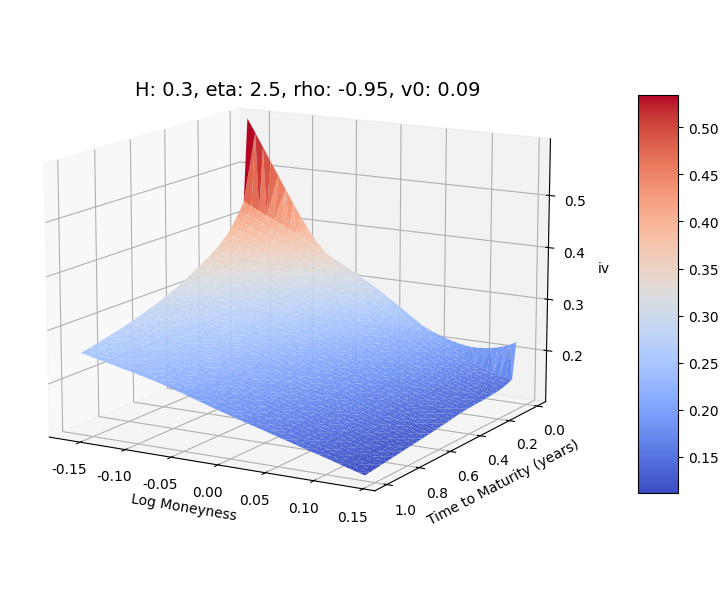

In [405]:
df_play = pd.DataFrame()
a = np.linspace(0.85, 1.15, 40)
b = np.linspace(0.01, 1, 40)
X,Y = np.meshgrid(a,b)
df_play['Moneyness'] = X.flatten()
df_play['Time to Maturity (years)'] = Y.flatten()
df_play['H'] = 0.3
df_play['eta'] = 2.5
df_play['rho'] = -0.95
df_play['v0'] = 0.09
scaled = SCALER.transform(df_play)
pred_iv = model.predict(scaled)
df_play['iv'] = pred_iv
df_play['Log Moneyness'] = np.log(df_play['Moneyness'])
plot_iv_surface_play(df_play, z='iv')

<b>Validation on real data </b>

<i>Reduce the dimensionality and re-grid</i>

In [185]:
df1 = helpers.load_month(2019,12,'SPX')
df1,len = helpers.split_days(df1, num_groups = 1)
df2 = df1[5]

#only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
#df = df[df[' [C_VOLUME]'] > 0]
df2 = df2[df2[' [C_VOLUME]'] != " "]
df2 = df2[df2[' [C_VOLUME]'] != ""]


daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
strikes = np.array(helpers.get_strike(df2))
implied_vols = np.array(helpers.get_IV_C(df2))
year, month, day = helpers.get_pricingdate(df2)
spot = helpers.get_underlyinglast(df2)
    
mean_vola = np.mean(implied_vols)

down = 0.835
up = 1.169

filter1 = strikes > down*spot
filter2 = strikes < up*spot
filter3 = daysaddasint > 0
filter4 = daysaddasint <= 368


filter = filter1 & filter2 & filter3 & filter4

implied_vols = implied_vols[filter].flatten()
strikes = strikes[filter].flatten()/spot
daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



#add some buckets to the grid which we will use later
adddays = np.linspace(0.01,1,6)
short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.05)*0.05,short_end))
#
strikesadd = np.round(np.linspace(0.85,1.15,9),2)
strikes = np.round(np.concatenate((strikes, strikesadd))/0.03)*0.03
atm = np.array(1.0).flatten()

strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
#10x np.nan
nans = np.repeat(np.nan, 10)
implied_vols = np.concatenate((implied_vols, nans))


daysaddasint_unique = sorted(np.unique(daysaddasint))

consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

#use mean in case of dublicates
consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# Pivot the dataframe to create the matrix
volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

#interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
#remove negative values after interpolation
volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

# outlier detection, one iteration already gives good results 
# we iterate over smiles and check each smile for outliers
for i, ds in enumerate(np.array(daysaddasint_unique)):
    first_col = volmatrix_interpolation.iloc[:, i]
    y = first_col.values
    # Smooth the data using a Savitzky-Golay filter
    
    # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
    diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

    #now we remove the outliers from the original matrix
    #without the interpolation, the outlier detection is not as good
    volmatrix.iloc[diff, i] = np.nan
    volmatrix_interpolation.iloc[diff, i] = np.nan

    
dates_unique = sorted(np.unique(volmatrix.columns))

strikes_unique = sorted(volmatrix.index.astype(float))



a = volmatrix.interpolate(method='quadratic', axis=0)
b = a.interpolate(method='quadratic', axis=1)
b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)

datf = b.stack().reset_index()
datf.columns = ['Strike', 'Time to Maturity', 'iv']

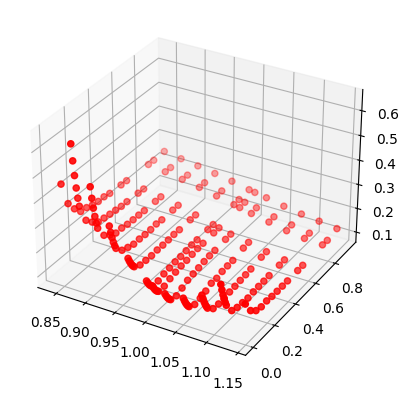

In [186]:
#scatter of the iv surface, should be regular, compare to unregularized surface below
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datf['Strike'], datf['Time to Maturity'], datf['iv'], c='r', marker='o')

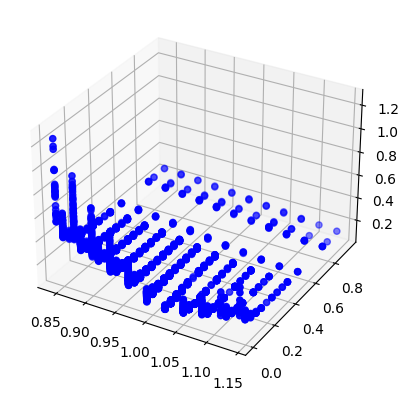

In [66]:
#scatter of the iv surface, should be regular without concentrated points, compare to unregularized surface below
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes, daysaddasint, implied_vols, c='b', marker='o')

In [67]:
initial_params = model_parameters_initializer('rBergomi')[0]
data = pd.DataFrame()
data['Moneyness'] = datf['Strike'].values
data['Time to Maturity (years)'] = datf['Time to Maturity'].values
#dummy to rescale
data['H'] = initial_params[0]
data['eta'] = initial_params[1]
data['rho'] = initial_params[2]
data['v0'] = initial_params[3]
datascaled = SCALER.transform(data)
moneyness = datascaled.iloc[:, 0]
time_to_maturity = datascaled.iloc[:, 1]
actual_vola = datf['iv'].values
initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space

In [69]:
#these are the bounds in the initial space
lower_bounds = [0, 0.2, -1, 0.0025]  # Lower bounds for H, eta, rho, v0
upper_bounds = [0.5, 4.5, 0, 2]   # Upper bounds for H, eta, rho, v0


#these are the bounds in the scaled space where the optimization is performed
dummy = pd.DataFrame()
dummy['Moneyness'] = np.array([0,0])
dummy['Time to Maturity (years)'] = np.array([0,0])
dummy['H'] = np.array([lower_bounds[0], upper_bounds[0]])
dummy['eta'] = np.array([lower_bounds[1], upper_bounds[1]])
dummy['rho'] = np.array([lower_bounds[2], upper_bounds[2]])
dummy['v0'] = np.array([lower_bounds[3], upper_bounds[3]])
dummy_scaled = SCALER.transform(dummy)
lower_bounds = dummy_scaled.iloc[0, 2:]
upper_bounds = dummy_scaled.iloc[1, 2:]
bounds = (lower_bounds, upper_bounds)
mid = (lower_bounds + upper_bounds)/2
bounds

(H     -2.044079
 eta   -2.705738
 rho   -1.535422
 v0    -0.741972
 Name: 0, dtype: float64,
 H      5.868248
 eta    3.057859
 rho    5.198873
 v0     3.284283
 Name: 1, dtype: float64)

<b>Application of manual solver</b>

In [266]:
result_manual = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)

7/7 [==============================] - 0s 2ms/step
Iteration: 0, Loss: 24.87329181895311
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 0.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 4.864227945892919
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 2.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 4.797189327621609
7/7 [==============================] - 0s 3ms/step
Learning rate increased to 9.6
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 4.7728557984472815
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 4.7667667369486395
7/7 [==============================] - 0s 2ms/step
Learning rate increased to 153.6
7/7 [=========

7/7 [==============================] - 0s 3ms/step
Mean relative error: 0.11770736347112049
Mean absolute error: 0.021856622388986956


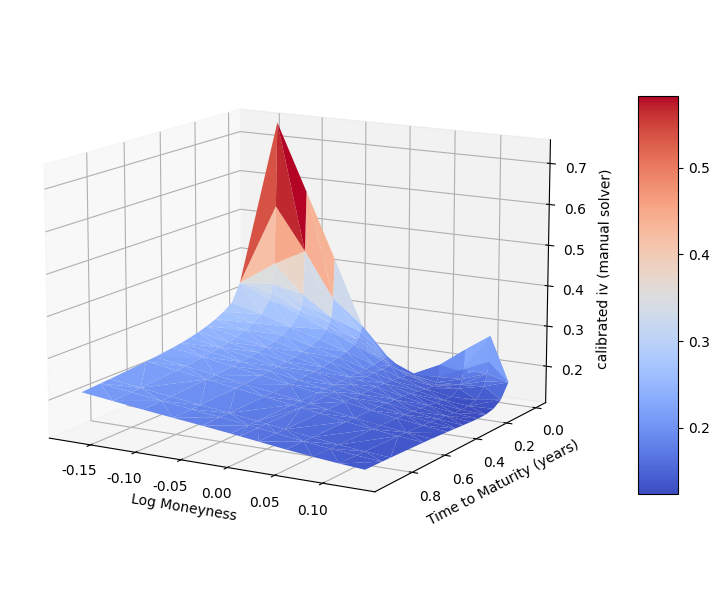

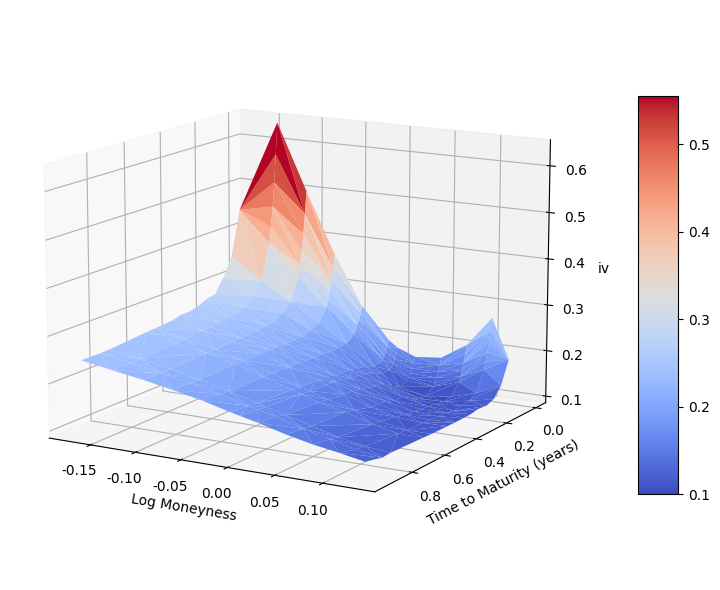

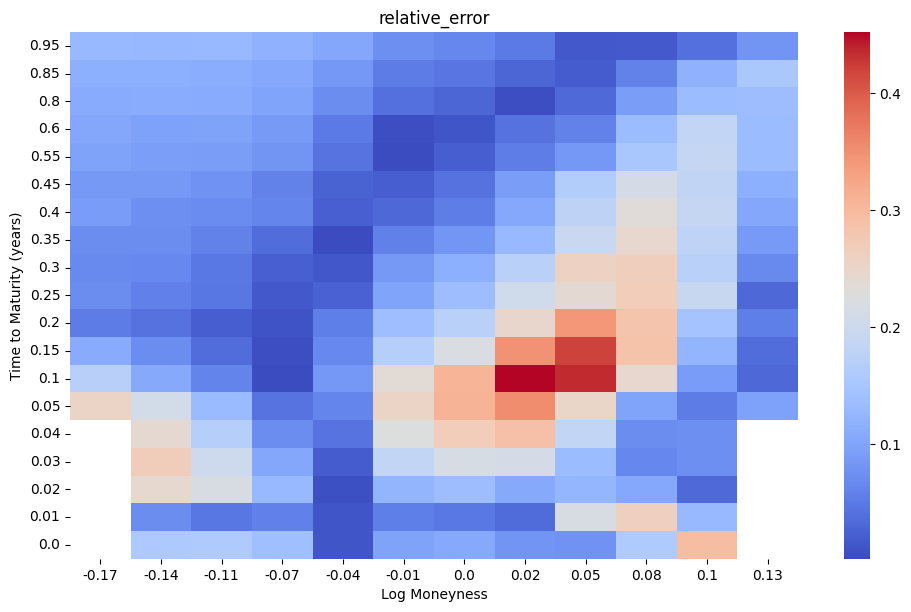

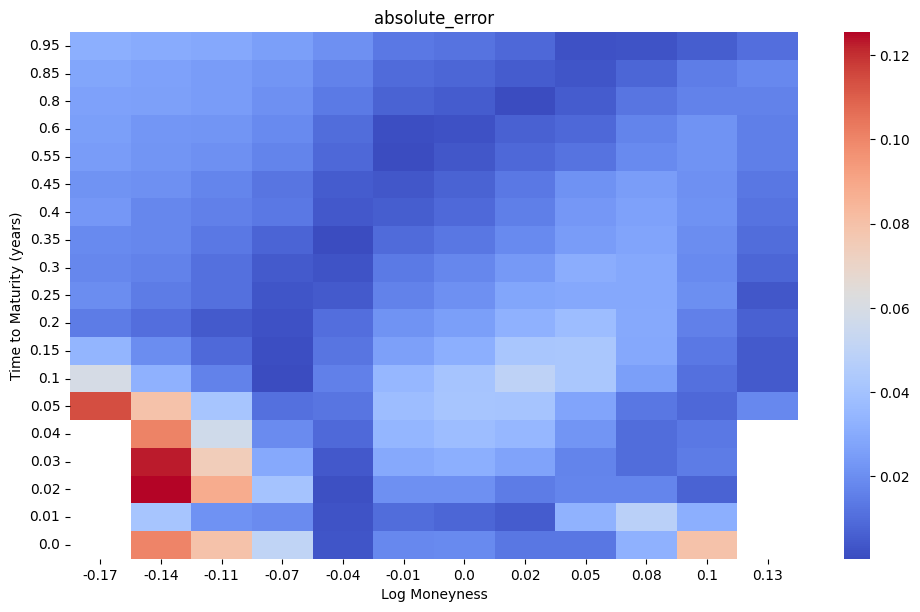

In [267]:
dfres_manual = pd.DataFrame()
dfres_manual['Moneyness'] = moneyness
dfres_manual['Time to Maturity (years)'] = time_to_maturity
dfres_manual['H'] = result_manual[0]
dfres_manual['eta'] = result_manual[1]
dfres_manual['rho'] = result_manual[2]
dfres_manual['v0'] = result_manual[3]
pred_iv = model.predict(dfres_manual)
dfres_manual = SCALER.inverse_transform(dfres_manual)
dfres_manual['calibrated iv (manual solver)'] = pred_iv
dfres_manual['iv'] = actual_vola
dfres_manual['relative_error'] = np.abs(dfres_manual['calibrated iv (manual solver)'] - dfres_manual['iv']) / dfres_manual['iv']
dfres_manual['Log Moneyness'] = np.log(dfres_manual['Moneyness'])
dfres_manual['absolute_error'] = np.abs(dfres_manual['calibrated iv (manual solver)'] - dfres_manual['iv'])
print("Mean relative error: {}".format(np.mean(dfres_manual['relative_error'])))
print("Mean absolute error: {}".format(np.mean(dfres_manual['absolute_error'])))
plot_iv_surface(dfres_manual, z='calibrated iv (manual solver)')
plot_iv_surface(dfres_manual, z='iv')
plot_heatmap(dfres_manual, 'relative_error')
plot_heatmap(dfres_manual, 'absolute_error')

In [268]:
H, eta, rho, v0 = np.round(dfres_manual.iloc[0, 2:6].values,4)
print("Calibrated parameters: ",H, eta, rho, v0)

Calibrated parameters:  0.0823 1.7792 -0.9147 0.0379


<b>Application on full data (dense grid and short end)</b>

In [36]:
#store the results in a df
results = pd.DataFrame(columns=['date', 'H', 'eta', 'rho', 'v0', 'rmse', 'mse', 'mae', 'median_se'])
subfolder_path = os.path.join(os.getcwd(), "rBergomiFiles")

year = 2019
for i in range(5,6):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

  
        

    for zz in range(1):

        df2 = df1[5]
            

        dates, percent = helpers.init()
        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]
      

        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 368


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.linspace(0.01,1,6)
        short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.05)*0.05,short_end))
        #
        strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.02)*0.02
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))

        #convert volmatrix back to df with 3 cols
        #datf = volmatrix.stack().reset_index()
        #mame cols
        #datf.columns = ['Strike', 'Time to Maturity', 'iv']

        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()

        b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)


        try:
            del b[0.0]
        except:
            pass

        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']


        rmse_best = 10000000.0
        
        for i in range(0,4):
            initial_params = model_parameters_initializer('rbergomi')[0]
            # parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later
            #test given the sample generated above to test the NN
            data = pd.DataFrame()
            data['Moneyness'] = datf['Moneyness'].values
            data['Time to Maturity (years)'] = datf['Time to Maturity'].values
            #dummy to rescale, not used
            data['H'] = initial_params[0]
            data['eta'] = initial_params[1]
            data['rho'] = initial_params[2]
            data['v0'] = initial_params[3]

            datascaled = SCALER.transform(data)
            moneyness = datascaled.iloc[:, 0].values
            time_to_maturity = datascaled.iloc[:, 1].values
            initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
            #calibrate to reach this vola
            actual_vola = datf['iv'].values                    #we try to retrieve the parameters we used to generate the surface in df
            

            result_manual, rmse, mse, mae, median_se = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)
            #convert the optimal parameters back to the original space
            if rmse < rmse_best:

                #convert the optimal parameters back to the original space
                    
                data = pd.DataFrame()
                data['Moneyness'] = [1.0]
                data['Time to Maturity (years)'] = [1.0]
                data['H'] = result_manual[0]
                data['eta'] = result_manual[1]
                data['rho'] = result_manual[2]
                data['v0'] = result_manual[3]

                rmse_best = rmse


                data = SCALER.inverse_transform(data)
                #split the result into the df
                results.loc[zz] = [date, data.iloc[0, 2], data.iloc[0, 3], data.iloc[0, 4], data.iloc[0, 5], rmse, mse, mae, median_se]

    results['rmse'] = results['rmse'].astype(float)
    results['mse'] = results['mse'].astype(float)
    results['mae'] = results['mae'].astype(float)
    results['median_se'] = results['median_se'].astype(float)

    #save the results and include the month and year in the filename
    file_path = os.path.join(subfolder_path, "rBergomi{}.csv".format(str(year)+str(month)))
    # results.to_csv(file_path, index=False)


11/11 [==============================] - 0s 3ms/step
Iteration: 0, Loss: 90.9347952766693
11/11 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
11/11 [==============================] - 0s 4ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 40.71950453250956
11/11 [==============================] - 0s 3ms/step
Learning rate increased to 2.4
11/11 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 40.26460213353564
11/11 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
11/11 [==============================] - 0s 2ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 40.18360964348246
11/11 [==============================] - 0s 3ms/step
Learning rate increased to 38.4
11/11 [==============================] - 0s 3ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 40.16424725344111
11/11 [==============================] - 0s 2ms/step
Learning rate increased to 153

In [37]:
results.iloc[-1]

date         2019-05-08
H              0.114276
eta            1.581882
rho           -1.148581
v0             0.337476
rmse           0.143496
mse            0.020591
mae            0.120763
median_se      0.011977
Name: 0, dtype: object

<b>Sample visualization</b>

In [42]:
data = pd.DataFrame()
data['Moneyness'] = datf['Moneyness'].values
data['Time to Maturity (years)'] = datf['Time to Maturity'].values
data['H'] = results.iloc[-1, 1]
data['eta'] = results.iloc[-1, 2]
data['rho'] = -1#results.iloc[-1, 3]
data['v0'] = results.iloc[-1, 4]
datascaled = SCALER.transform(data)
pred_iv = model.predict(datascaled)
data['rBergomivola'] = pred_iv 
data['Implied Volatility'] = datf['iv'].values
data['Log Moneyness'] = np.log(data['Moneyness'])
H, eta, rho, v0  = results.iloc[-1, 1:5].values

11/11 [==============================] - 0s 3ms/step


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [32]:
def plot_iv_surface_play(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x, fontsize=13)
    ax.set_ylabel(y, fontsize=13)
    #put z title right of the axis
    ax.set_zlabel(z, fontsize=13, position=(1.1, 0.5))

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap='coolwarm')
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    ax.set_title('')
    plt.tight_layout()


    # Add centered text below the chart, rounded to 2 decimal places
    header_text = 'H: {}, eta: {}, rho: {}, v0: {}'.format(H, eta, rho, v0)
    ax.text2D(0.22, 0.85, header_text, transform=ax.transAxes, fontsize=14)
    header_text = 'Market Implied Volatility'
    # ax.text2D(0.28, 0.85, header_text, transform=ax.transAxes, fontsize=18)
    #add date as text
    ax.text2D(0.45, 0.9, date, transform=ax.transAxes, fontsize=18)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #size of vertical axis
    ax.zaxis.set_tick_params(labelsize=13)
    #round horizontal axis to 2 decimals
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


    plt.show()
    # plt.tight_layout()


In [43]:
H = np.round(H,2)
eta = np.round(eta,2)
rho = np.round(rho,2)
v0 = np.round(v0,2)

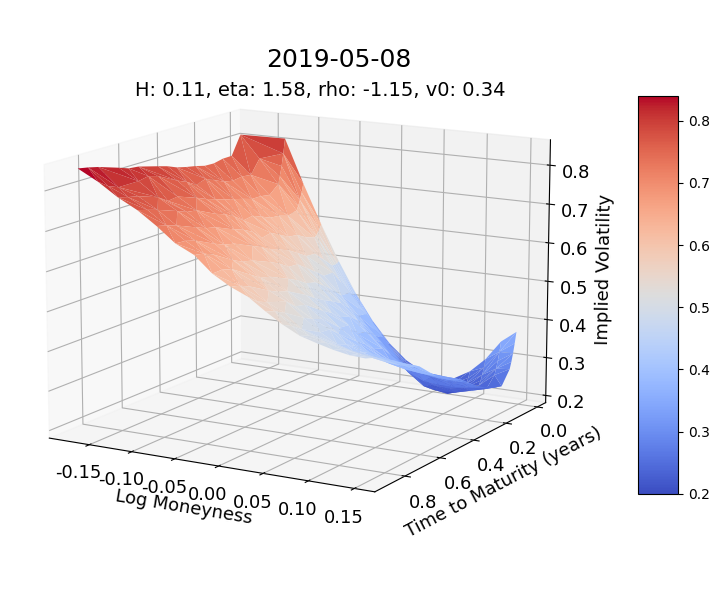

In [44]:
plot_iv_surface_play(data, z='Implied Volatility')

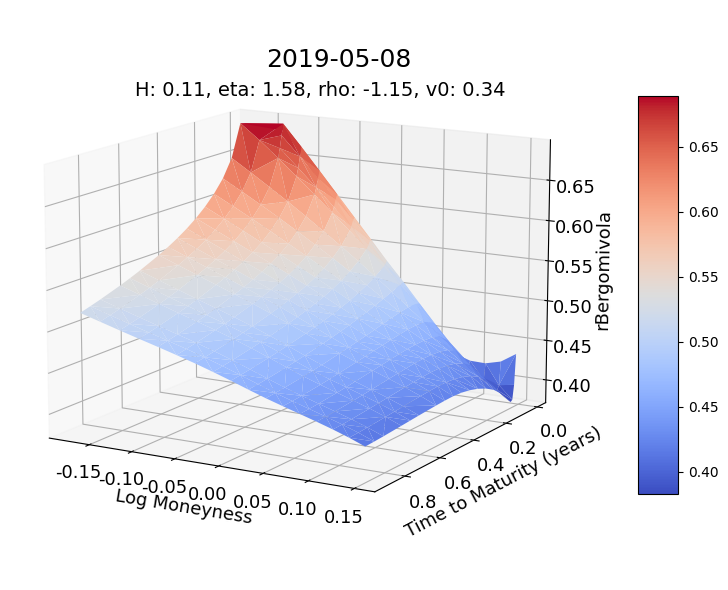

In [45]:
plot_iv_surface_play(data, z='rBergomivola')

<b>Sample Smiles</b>

In [658]:
#change b pivot index to log moneyness
b.index = np.log(b.index)

In [678]:
b_0005 = b.loc[:,0.05]
b_001 = b.loc[:,0.10]
b_005 = b.loc[:,0.20]
b_010 = b.loc[:,0.40]

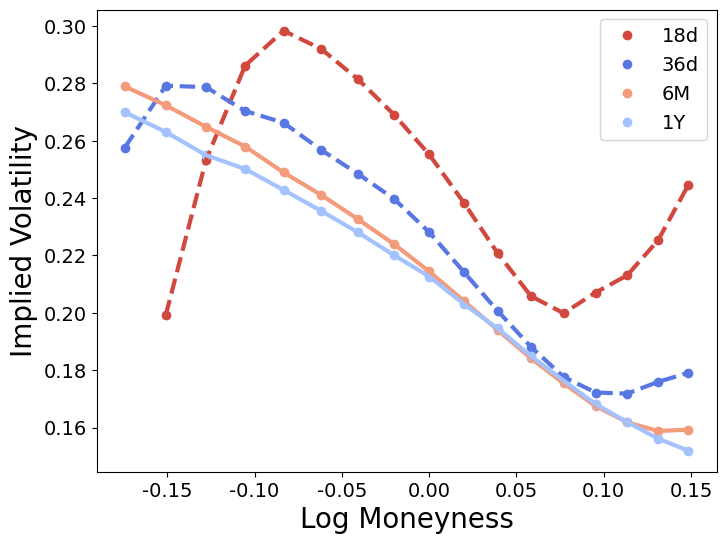

In [679]:
# Plot the smiles all into one plot, larger text size
fig, ax = plt.subplots(figsize=(8, 6))
#hex codes: #D1483E, #5977E3, #F49B7C, #A3C2FE
# Data points with markers, make text size larger
ax.plot(b_0005.index, b_0005.values, marker='o', linestyle='None', label='18d', color='#D1483E', markersize=6)
ax.plot(b_001.index, b_001.values, marker='o', linestyle='None', label='36d', color='#5977E3', markersize=6)
ax.plot(b_005.index, b_005.values, marker='o', linestyle='None', label='6M', color='#F49B7C', markersize=6)
ax.plot(b_010.index, b_010.values, marker='o', linestyle='None', label='1Y', color='#A3C2FE', markersize=6)

# Dashed lines connecting the data points
ax.plot(b_0005.index, b_0005.values, linestyle='dashed', color='#D1483E', linewidth=3)
ax.plot(b_001.index, b_001.values, linestyle='dashed', color='#5977E3', linewidth=3)
ax.plot(b_005.index, b_005.values, linestyle='solid', color='#F49B7C', linewidth=3)
ax.plot(b_010.index, b_010.values, linestyle='solid', color='#A3C2FE', linewidth=3)

ax.legend(loc='upper right', fontsize=14)
ax.set_xlabel('Log Moneyness', fontsize=20)
ax.set_ylabel('Implied Volatility', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
#font size of the ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()


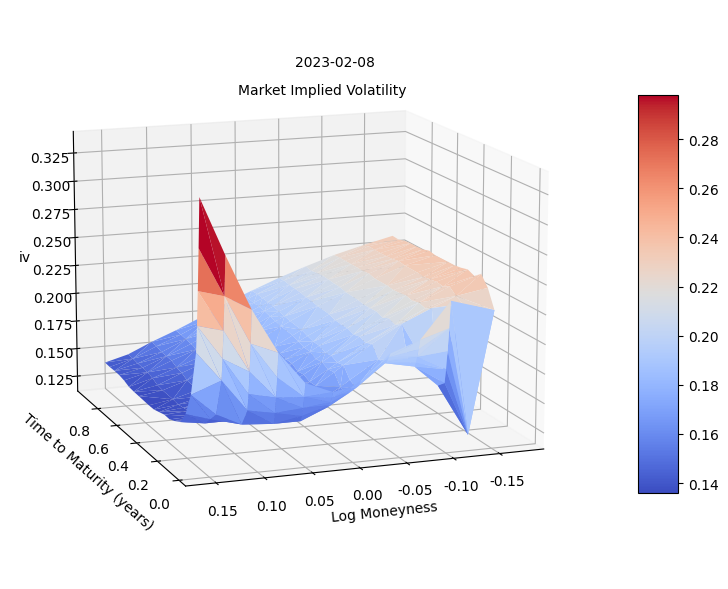

In [298]:
plot_iv_surface_play(data, z='iv')

In [64]:
def plot_heatmap(data, values='re'):            #adjusted heatmap for paper plots
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values, fontsize=22)
    plt.xlabel('Log Moneyness', fontsize=22)
    plt.ylabel('Time to Maturity (years)', fontsize=22)
    # Adjust x-axis tick labels
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=16)
    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    plt.show()


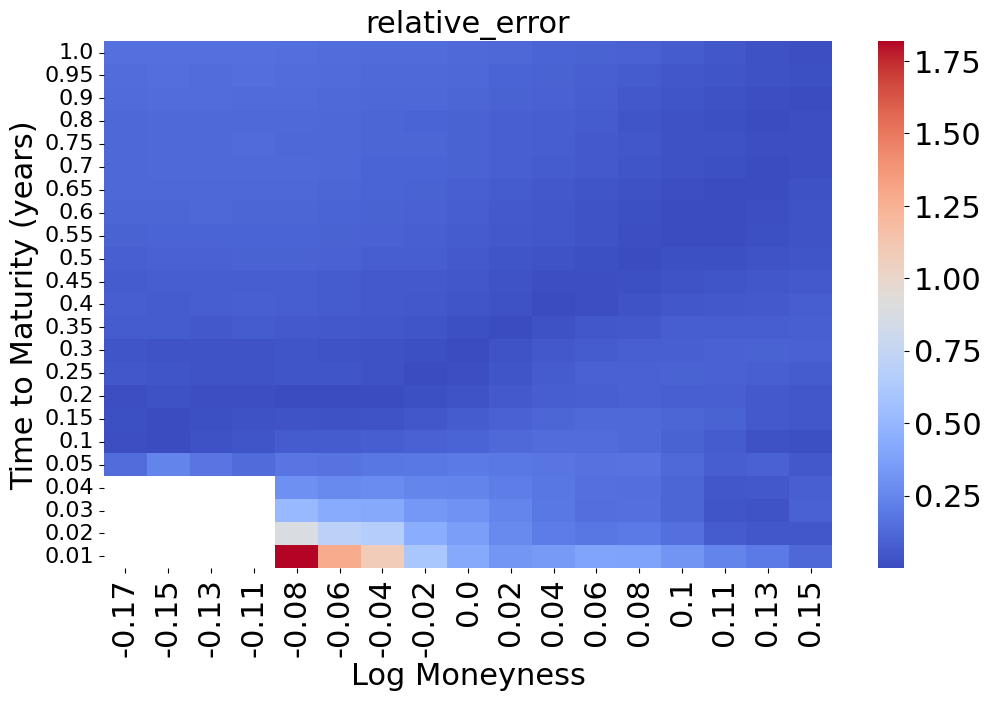

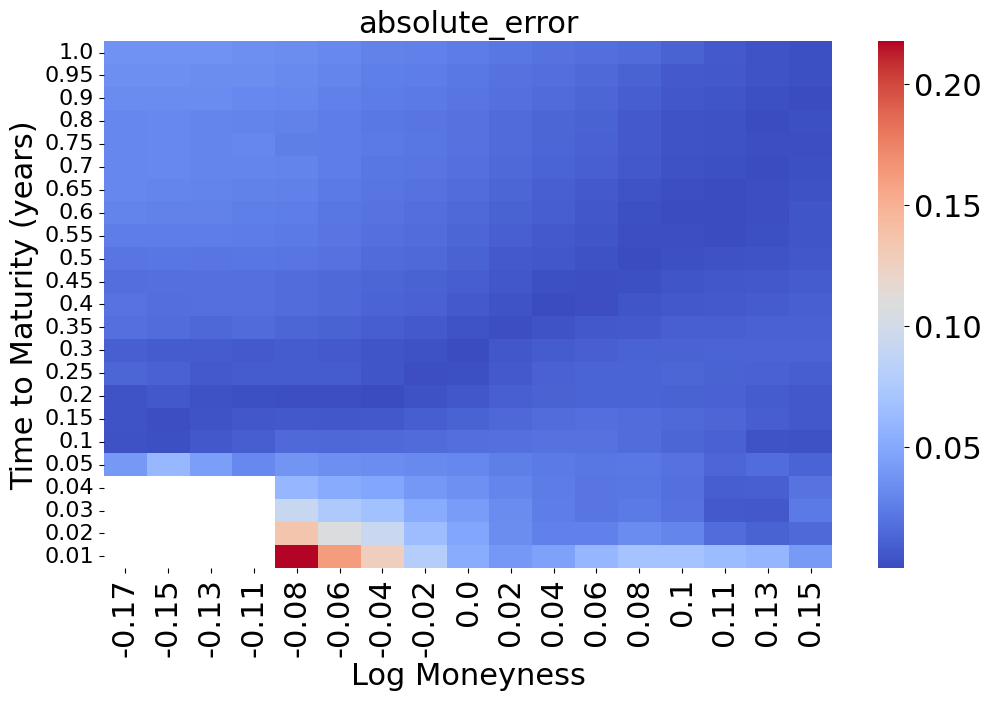

In [422]:
#relative error and absolute error
data['relative_error'] = np.abs(data['rBergomivola'] - data['Implied Volatility']) / data['Implied Volatility']
data['absolute_error'] = np.abs(data['rBergomivola'] - data['Implied Volatility'])
plot_heatmap(data, 'relative_error')
plot_heatmap(data, 'absolute_error')

<b>Calibration on fewer data (less dense grid)</b>

In [68]:
#store the results in a df
results = pd.DataFrame(columns=['date', 'H', 'eta', 'rho', 'v0', 'rmse', 'mse', 'mae', 'median_se'])
subfolder_path = os.path.join(os.getcwd(), "rBergomi files small grid")

year = 2023
for i in range(1,4):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

  
        

    for zz in range(len):

        df2 = df1[zz]
            

        dates, percent = helpers.init()
        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]
      

        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 368


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.linspace(0.5,1,6)
        short_end = np.linspace(0.5,1,4)
        #short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.1)*0.1,short_end))
        #
        #strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikesadd = np.repeat(0.85, 9)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.05)*0.05
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))

        #convert volmatrix back to df with 3 cols
        #datf = volmatrix.stack().reset_index()
        #mame cols
        #datf.columns = ['Strike', 'Time to Maturity', 'iv']

        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()

        b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        try:
            del b[0.0]
        except:
            pass
        
        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']


        rmse_best = 10000000.0
        
        for i in range(0,4):
            initial_params = model_parameters_initializer('rbergomi')[0]
            # parameters have to be scaled into the NN dimensions in order not to be out of bounds during initialization, done later
            #test given the sample generated above to test the NN
            data = pd.DataFrame()
            data['Moneyness'] = datf['Moneyness'].values
            data['Time to Maturity (years)'] = datf['Time to Maturity'].values
            #dummy to rescale, not used
            data['H'] = initial_params[0]
            data['eta'] = initial_params[1]
            data['rho'] = initial_params[2]
            data['v0'] = initial_params[3]

            datascaled = SCALER.transform(data)
            moneyness = datascaled.iloc[:, 0].values
            time_to_maturity = datascaled.iloc[:, 1].values
            initial_params = datascaled.iloc[0, 2:].values      #initial guess is rescaled to the NN feature space
            #calibrate to reach this vola
            actual_vola = datf['iv'].values                    #we try to retrieve the parameters we used to generate the surface in df
            

            result_manual, rmse, mse, mae, median_se = manual_solver(initial_params, learning_rate=0.3, max_iterations=1000, tolerance = 1e-9, LR_lower=0.25, LR_upper=0.75)
            #convert the optimal parameters back to the original space
            if rmse < rmse_best:

                #convert the optimal parameters back to the original space
                    
                data = pd.DataFrame()
                data['Moneyness'] = [1.0]
                data['Time to Maturity (years)'] = [1.0]
                data['H'] = result_manual[0]
                data['eta'] = result_manual[1]
                data['rho'] = result_manual[2]
                data['v0'] = result_manual[3]

                rmse_best = rmse


                data = SCALER.inverse_transform(data)
                #split the result into the df
                results.loc[zz] = [date, data.iloc[0, 2], data.iloc[0, 3], data.iloc[0, 4], data.iloc[0, 5], rmse, mse, mae, median_se]

    results['rmse'] = results['rmse'].astype(float)
    results['mse'] = results['mse'].astype(float)
    results['mae'] = results['mae'].astype(float)
    results['median_se'] = results['median_se'].astype(float)

    #save the results and include the month and year in the filename
    file_path = os.path.join(subfolder_path, "rBergomi{}.csv".format(str(year)+str(month)))
    results.to_csv(file_path, index=False)


3/3 [==============================] - 0s 2ms/step
Iteration: 0, Loss: 5.561762801116922
3/3 [==============================] - 0s 2ms/step
Learning rate increased to 0.6
3/3 [==============================] - 0s 3ms/step
Learning rate increased to 1.2
Iteration: 2, Loss: 1.4424082384458277
3/3 [==============================] - 0s 3ms/step
Learning rate increased to 2.4
3/3 [==============================] - 0s 2ms/step
Learning rate increased to 4.8
Iteration: 4, Loss: 1.4118400400871753
3/3 [==============================] - 0s 2ms/step
Learning rate increased to 9.6
3/3 [==============================] - 0s 3ms/step
Learning rate increased to 19.2
Iteration: 6, Loss: 1.407521966695261
3/3 [==============================] - 0s 2ms/step
Learning rate increased to 38.4
3/3 [==============================] - 0s 3ms/step
Learning rate increased to 76.8
Iteration: 8, Loss: 1.4064578151697635
3/3 [==============================] - 0s 3ms/step
Learning rate increased to 153.6
3/3 [========

In [52]:
results.iloc[-1]

date         2020-10-30
H              0.104274
eta            2.450194
rho           -0.681179
v0             0.106543
rmse           0.014319
mse            0.000205
mae            0.011728
median_se      0.000107
Name: 21, dtype: object

<b>Visualize Time Series</b>

In [21]:
#load all files from
import os
import pandas as pd
subfolder_path = os.path.join(os.getcwd(), "rBergomiFiles")
files = os.listdir(subfolder_path)
files = [f for f in files if f.endswith('.csv')]
#load files to csv
df = pd.DataFrame()
for f in files:
    df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
allresults = df.copy()
df.head()

C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\195930660.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\195930660.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\195930660.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\195930660.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.a

date         H       eta       rho        v0      rmse       mse  \
0 2019-01-02  0.103842  2.028607 -0.796568  0.061569  0.017432  0.000304   
1 2019-01-03  0.120905  2.311045 -0.910688  0.089299  0.018477  0.000341   
2 2019-01-04  0.120193  2.362253 -0.837018  0.069757  0.024913  0.000621   
3 2019-01-07  0.087516  2.274025 -0.893221  0.062329  0.018830  0.000355   
4 2019-01-08  0.080201  2.326566 -0.930105  0.059901  0.019750  0.000390   

        mae  median_se  
0  0.013052   0.000091  
1  0.011060   0.000061  
2  0.018618   0.000219  
3  0.014271   0.000146  
4  0.015904   0.000222

In [20]:
df2 = df.copy()

In [22]:
df = df[df['H']>0]
#filter all values where rmse is 50% above 30 days moving rmse
df = df[df['rmse'] < 2*df['rmse'].rolling(5).min()]
df = df[df['rho'] > -1]

In [23]:
#make additional 30 day moving average column
df['rmse_30d'] = df['rmse'].rolling(30).mean()
df['mae_30d'] = df['mae'].rolling(30).mean()
df['mse_30d'] = df['mse'].rolling(30).mean()
df['median_se_30d'] = df['median_se'].rolling(30).mean()
df['H_30d'] = df['H'].rolling(30).mean()
df['eta_30d'] = df['eta'].rolling(30).mean()
df['rho_30d'] = df['rho'].rolling(30).mean()
df['v0_30d'] = df['v0'].rolling(30).mean()

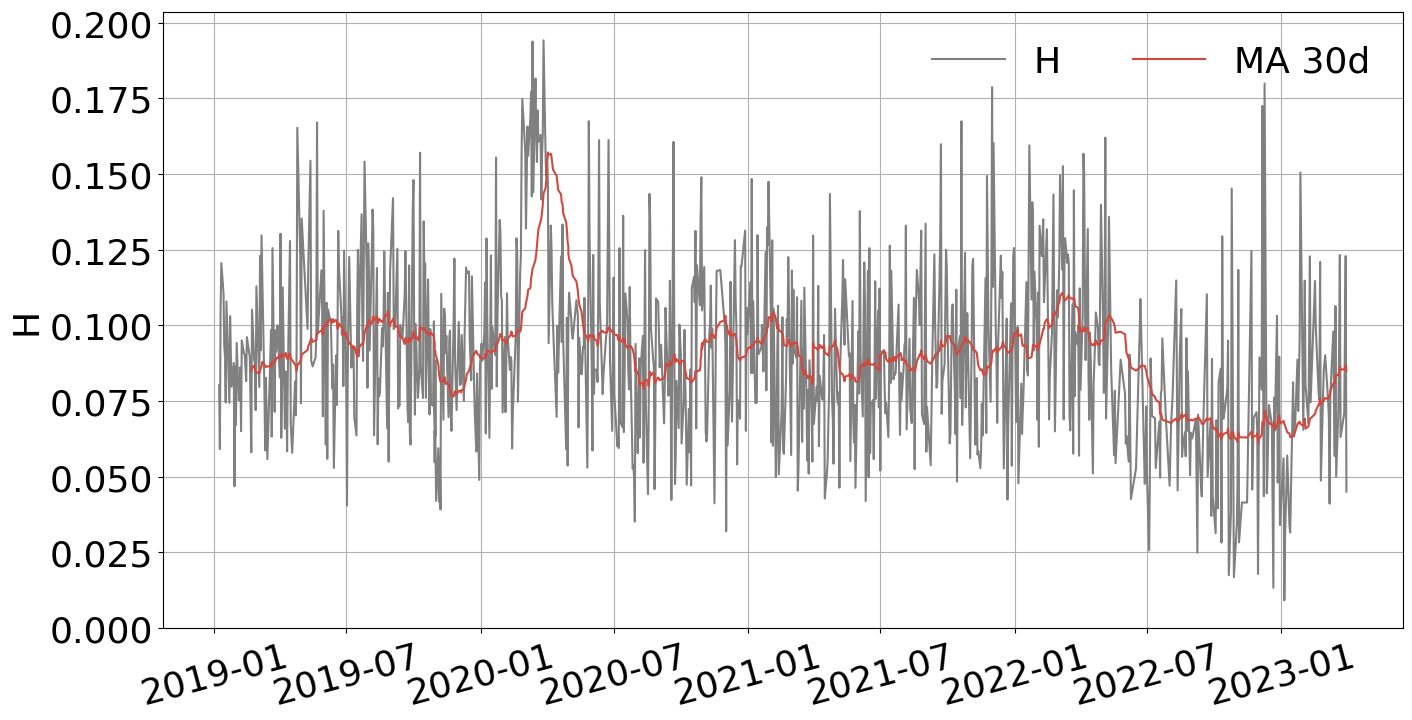

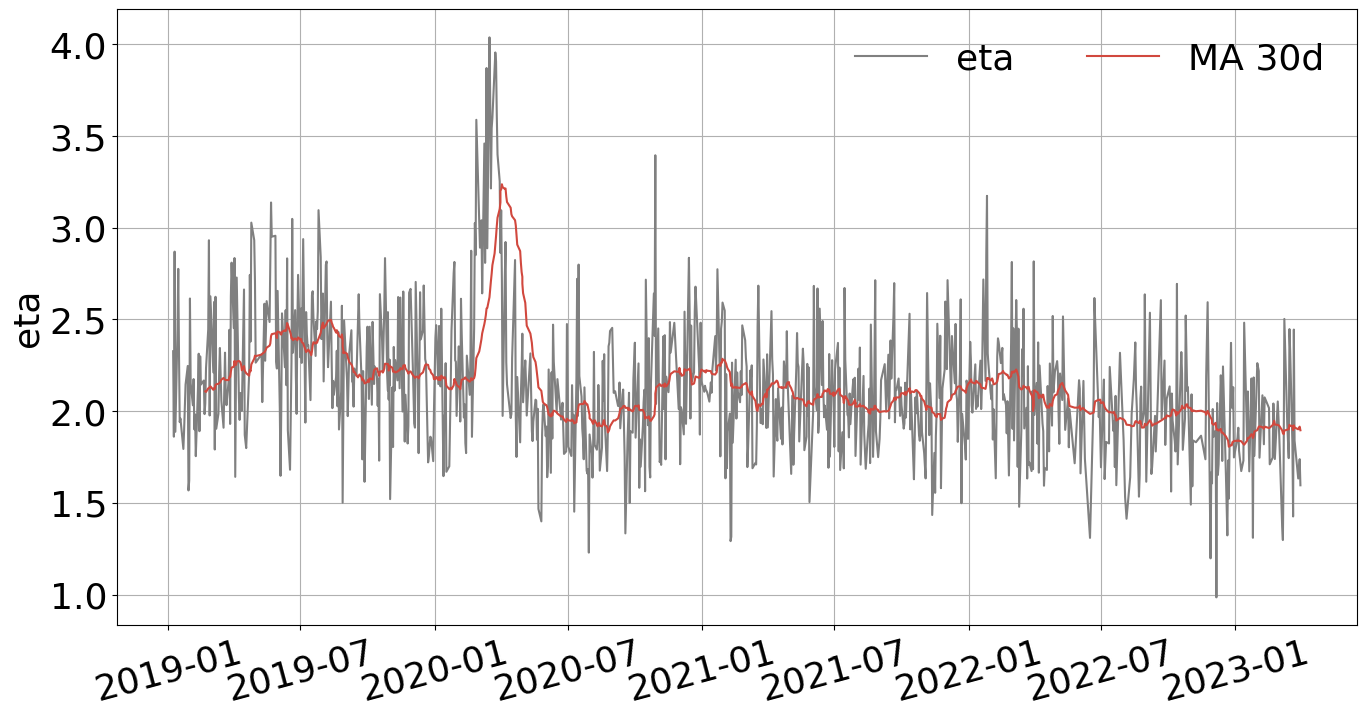

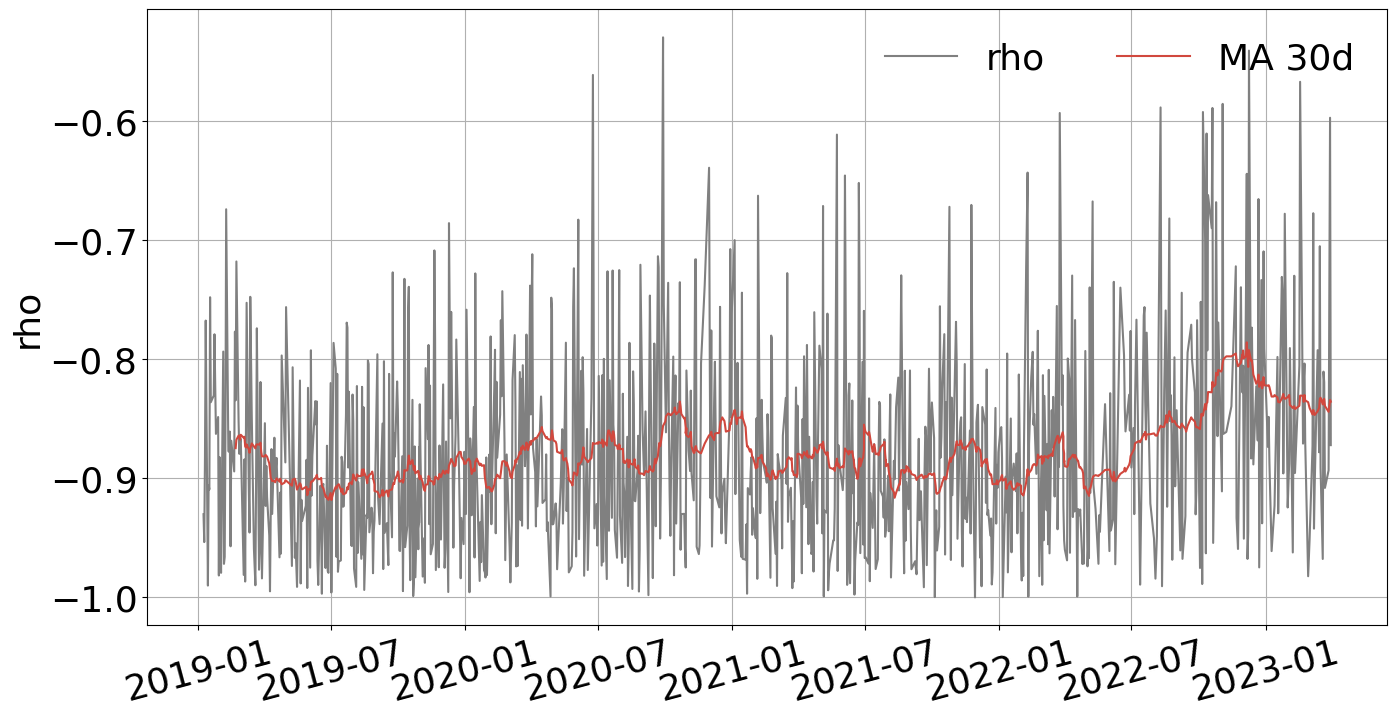

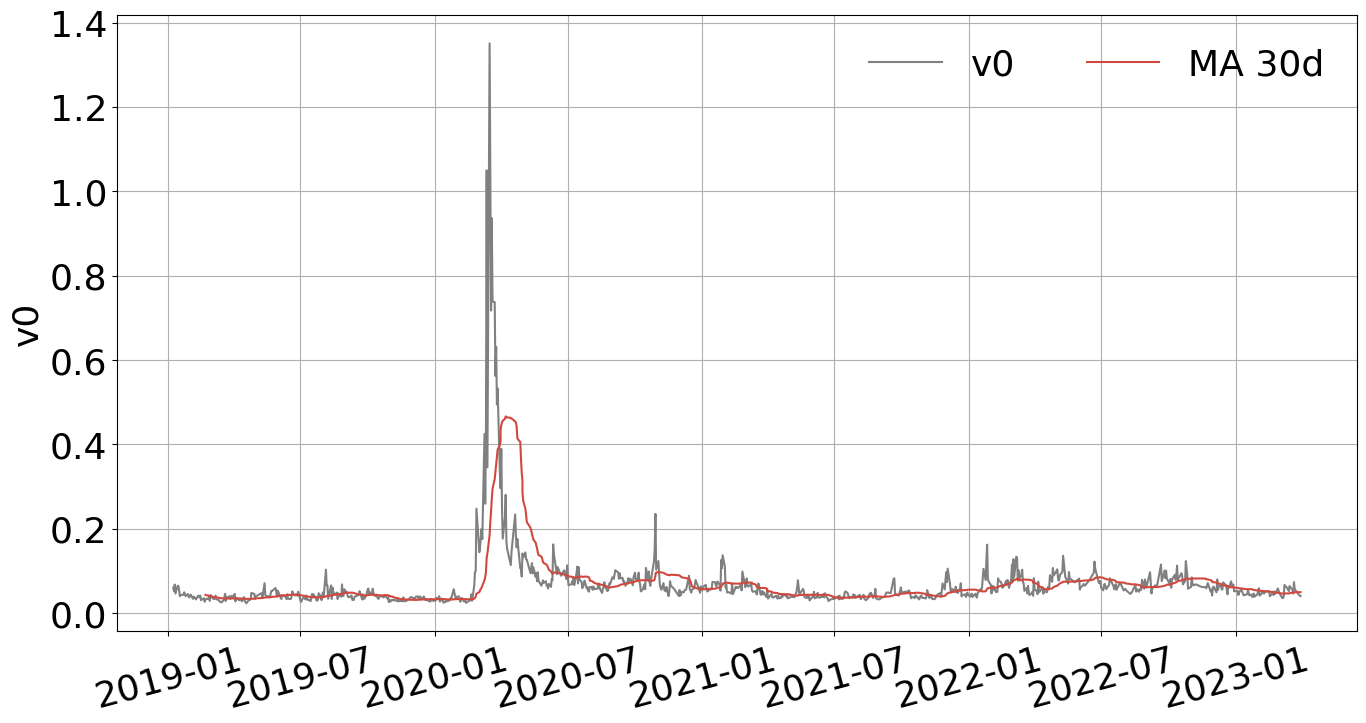

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['H'], color='grey')
plt.plot(df['date'], df['H_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['H','MA 30d'], loc="upper right", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('H', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['eta'], color='grey')
plt.plot(df['date'], df['eta_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['eta','MA 30d'], loc="upper right", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('eta', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['rho'], color='grey')
plt.plot(df['date'], df['rho_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['rho','MA 30d'], loc="upper right", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('rho', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()
############################################################################################################
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['v0'], color='grey')
plt.plot(df['date'], df['v0_30d'], color='#D1483E')
# Display no data here but make blue line for legend
plt.legend(labels=['v0','MA 30d'], loc="upper right", frameon=False, fontsize=26,  ncols=3)
# Secondary axis

plt.grid(True)
# Axis labels
plt.ylabel('v0', fontsize=26)
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)
plt.show()

In [25]:
df['rmedian_se'] = np.sqrt(df['median_se'])

In [26]:
print("rmse: ", np.mean(df['rmse']))
print("mse: ", np.mean(df['mse']))
print("mae: ", np.mean(df['mae']))
print("root median_se: ", np.mean(df['rmedian_se']))

rmse:  0.023570067676225652
mse:  0.0005978986811966438
mae:  0.01726057496518967
root median_se:  0.013910715815752372


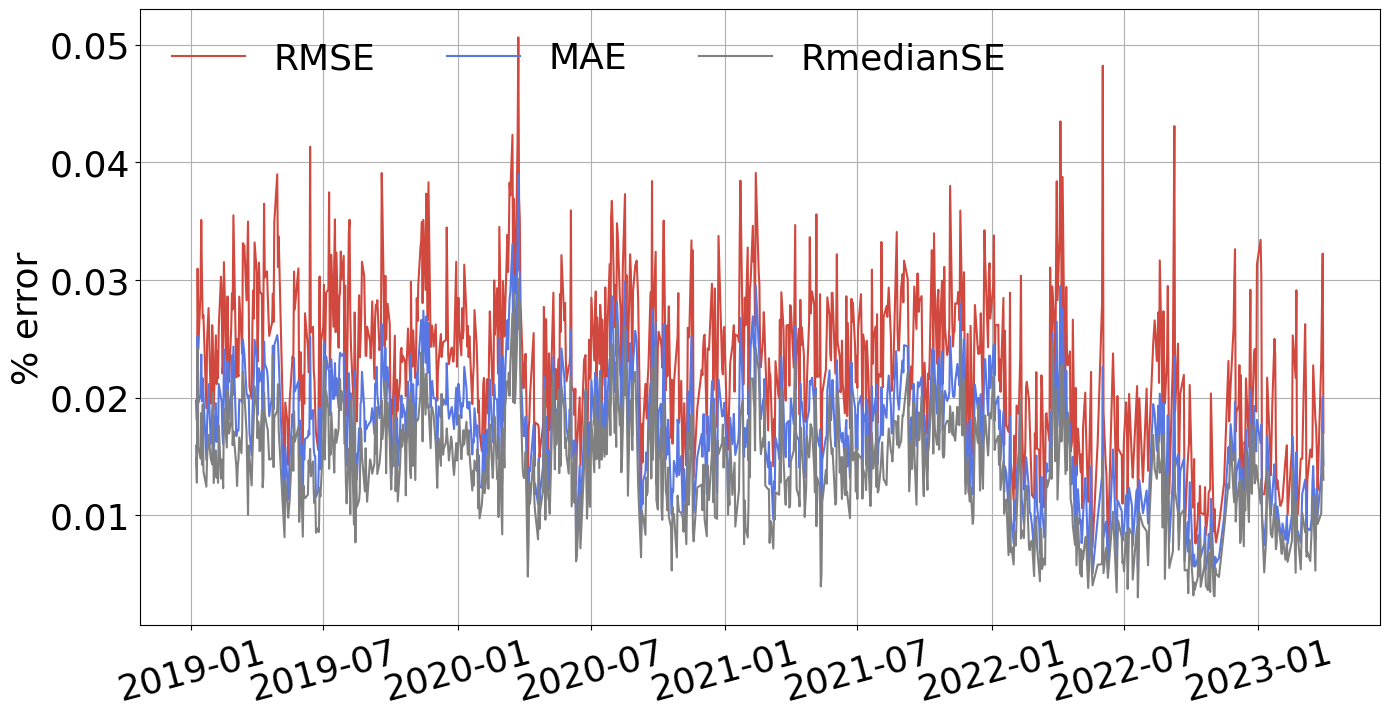

In [27]:
# Plot all lines in a single plot
plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['rmse'], color='#D1483E', label='RMSE')
plt.plot(df['date'], df['mae'], color='#5977E3', label='MAE')
plt.plot(df['date'], df['rmedian_se'], color='grey', label='RmedianSE')

plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error', fontsize=26)
#add second axis with same scale

# Rename and show the legend
plt.legend(loc='upper left', fontsize=26, frameon=False, ncol=3)
#tick size
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)


plt.show()

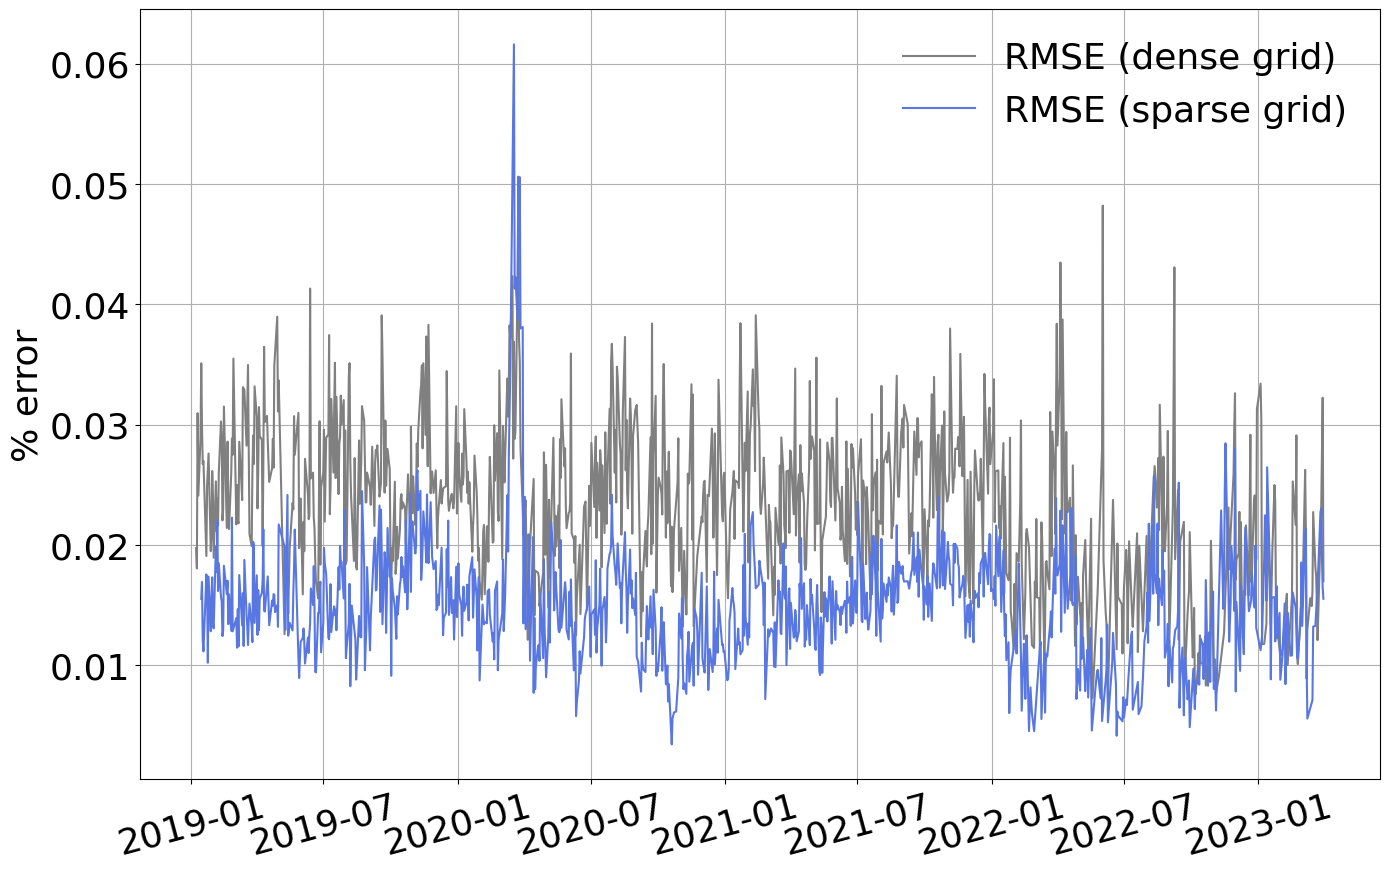

In [40]:
# Plot all lines in a single plot
plt.figure(figsize=(16, 10))
plt.plot(df['date'], df['rmse'], color='grey', label='RMSE (dense grid)')
# plt.plot(df['date'], df['mae'], color='#5977E3', label='MAE')
# plt.plot(df['date'], df['rmedian_se'], color='#D1483E', label='RmedianSE (dense grid)')
plt.plot(df2['date'], df2['rmse'], color='#5977E3', label='RMSE (sparse grid)')
plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error', fontsize=26)
#add second axis with same scale

# Rename and show the legend
plt.legend(loc='upper right', fontsize=26, frameon=False, ncol=1)
#tick size
plt.xticks(fontsize=26, rotation=15)
plt.yticks(fontsize=26)


plt.show()

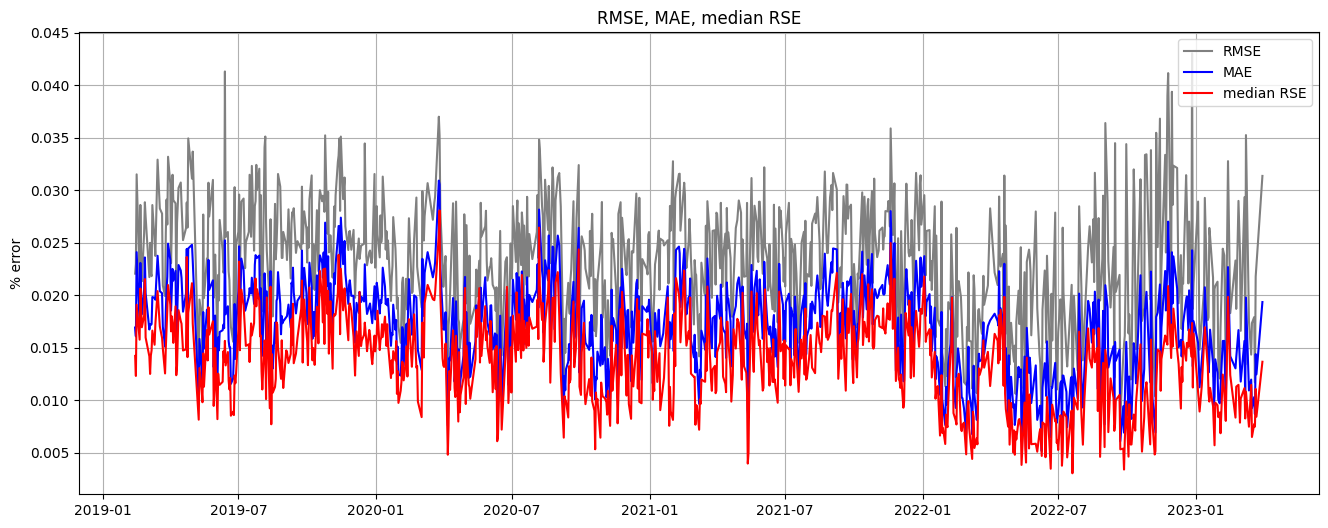

In [104]:
# Plot all lines in a single plot
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['rmse'], color='grey', label='RMSE')
plt.plot(df['date'], df['mae'], color='blue', label='MAE')
plt.plot(df['date'], df['rmedian_se'], color='red', label='median RSE')

# Set title and grid
plt.title('RMSE, MAE, median RSE')
plt.grid(True)

# Set y-axis label and percentage formatting
plt.ylabel('% error')


# Rename and show the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


<b>Error less dense grid</b>

In [149]:
#load all files from
import os
import pandas as pd
subfolder_path = os.path.join(os.getcwd(), "rBergomi files small grid")
files = os.listdir(subfolder_path)
files = [f for f in files if f.endswith('.csv')]
#load files to csv
df1 = pd.DataFrame()
for f in files:
    df1 = df1.append(pd.read_csv(os.path.join(subfolder_path, f)))
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values('date')
allresults = df1.copy()
df1.head()

C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\3308197103.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\3308197103.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\3308197103.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(pd.read_csv(os.path.join(subfolder_path, f)))
C:\Users\caspa\AppData\Local\Temp\ipykernel_26480\3308197103.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

date         H       eta       rho        v0      rmse       mse  \
0 2019-01-02  0.077796  1.883622 -0.936383  0.064296  0.006531  0.000043   
1 2019-01-03  0.113463  2.389226 -0.830499  0.087580  0.007817  0.000061   
2 2019-01-04  0.076821  1.928287 -0.835738  0.062136  0.009365  0.000088   
3 2019-01-07  0.096135  1.540210 -0.869355  0.056935  0.008914  0.000079   
4 2019-01-08  0.051809  2.398882 -0.845479  0.060140  0.015908  0.000253   

        mae  median_se  
0  0.004819   0.000015  
1  0.006364   0.000032  
2  0.007650   0.000053  
3  0.006955   0.000031  
4  0.012542   0.000146

In [150]:
df1 = df1[df1['H']>0]
#filter all values where rmse is 50% above 30 days moving rmse
df1 = df1[df1['rmse'] < 2*df1['rmse'].rolling(30).mean()]
df1 = df1[df1['rho'] > -1]

In [153]:
df1['rmedian_se'] = np.sqrt(df1['median_se'])

In [154]:
print("rmse: ", np.mean(df1['rmse']))
print("mse: ", np.mean(df1['mse']))
print("mae: ", np.mean(df1['mae']))
print("root median_se: ", np.mean(df1['rmedian_se']))

rmse:  0.015199610215718836
mse:  0.00025754051278271235
mae:  0.011993427370430155
root median_se:  0.010528728402499084


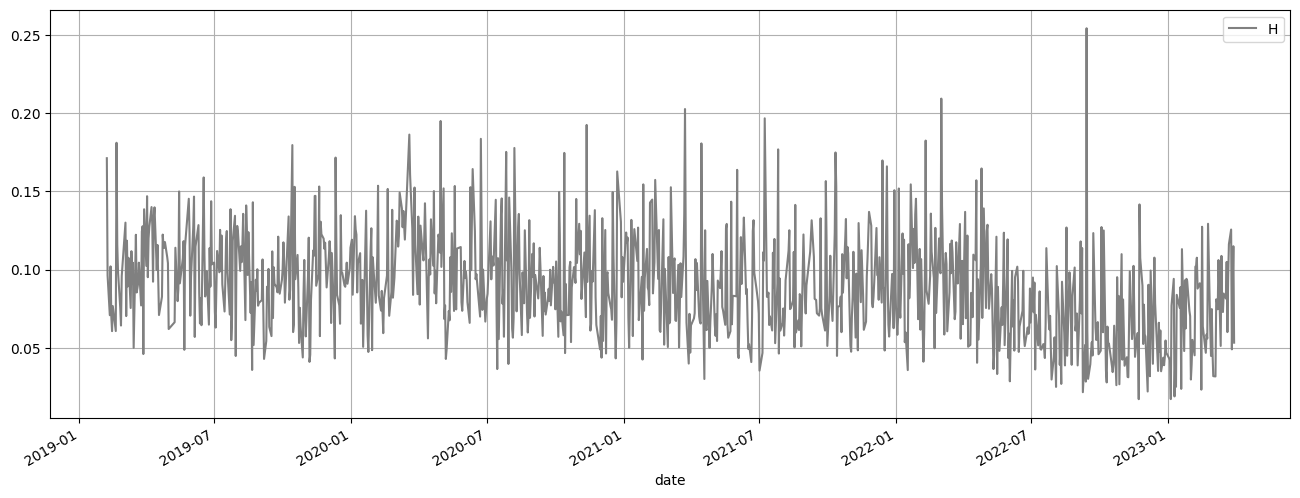

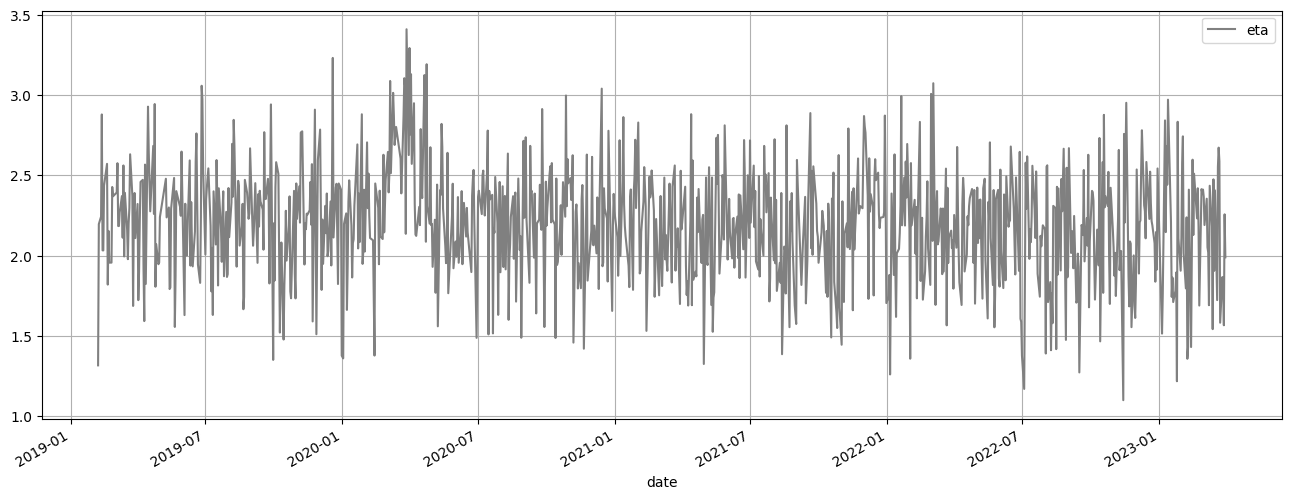

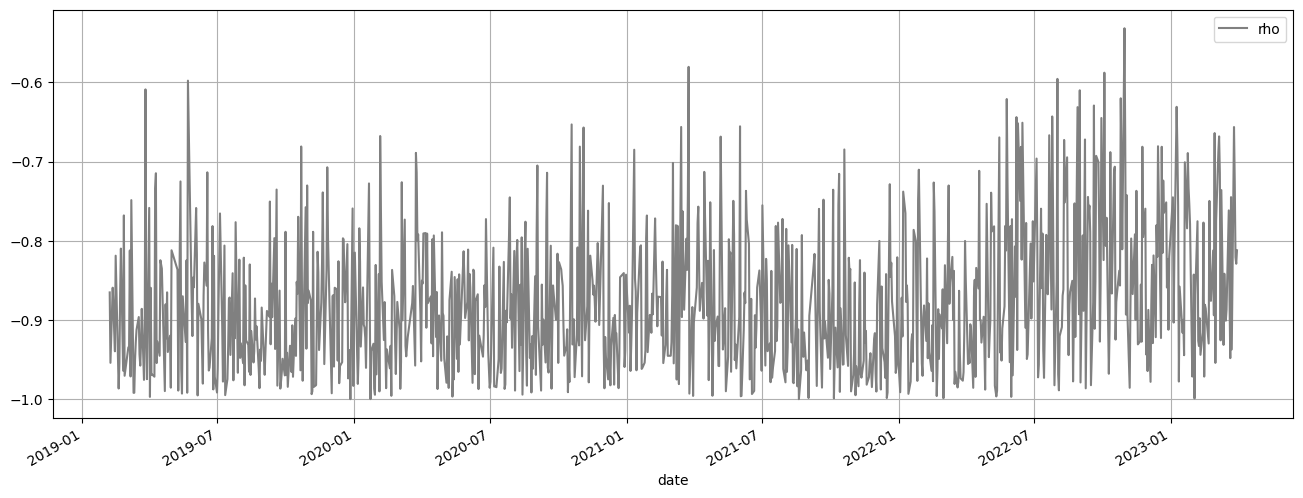

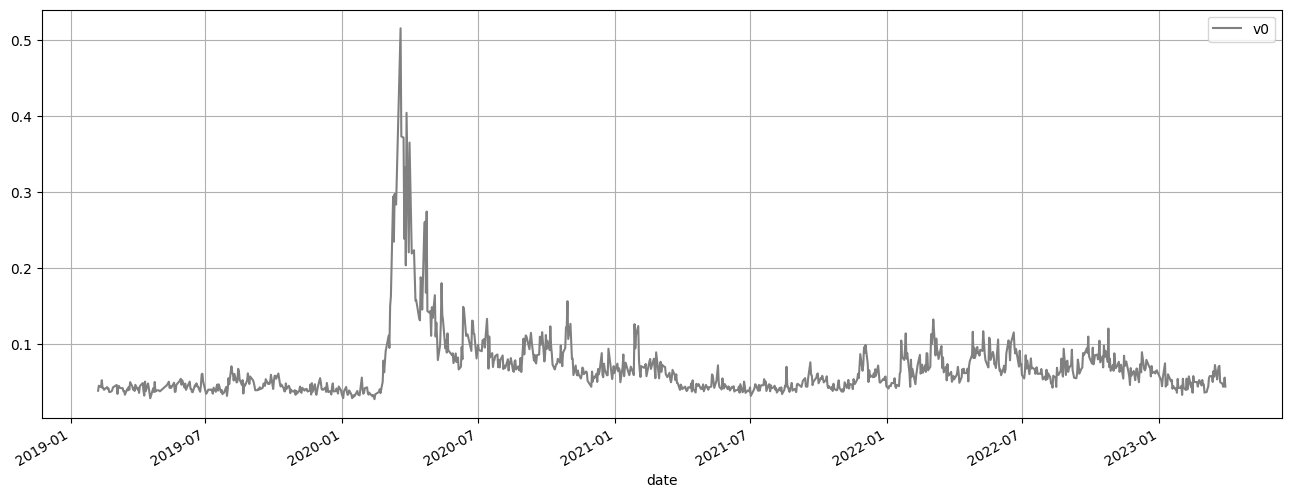

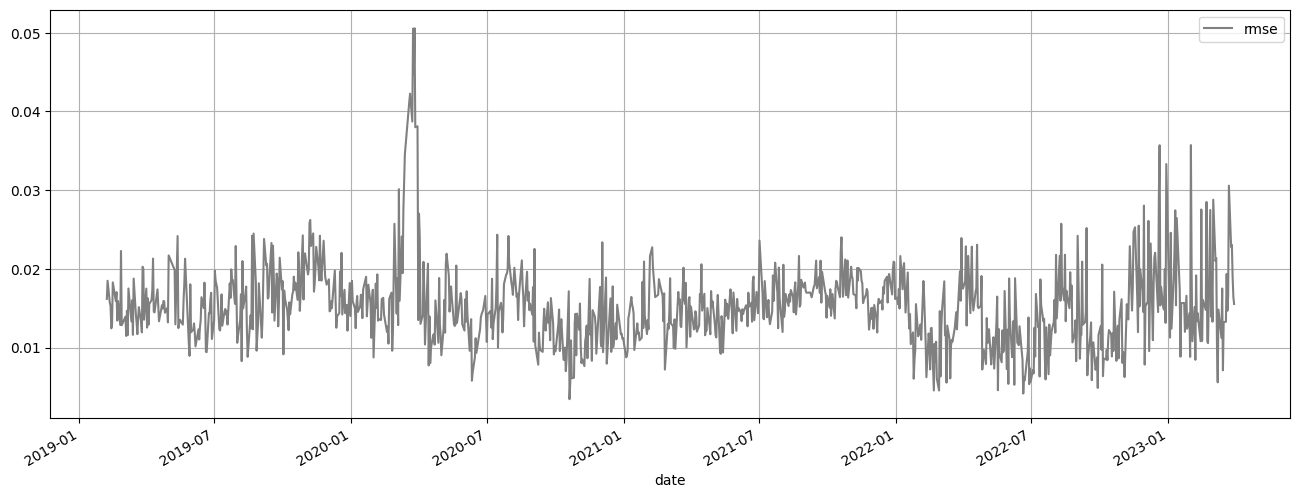

In [129]:
#plot the history of all 5 parameters
df1.plot(x='date', y=['H'], figsize=(16, 6), grid=True, color = 'grey')
df1.plot(x='date', y=['eta'], figsize=(16, 6), grid=True, color = 'grey')
df1.plot(x='date', y=['rho'], figsize=(16, 6), grid=True, color = 'grey')
df1.plot(x='date', y=['v0'], figsize=(16, 6), grid=True, color = 'grey')
df1.plot(x='date', y=['rmse'], figsize=(16, 6), grid=True, color = 'grey')
plt.show()

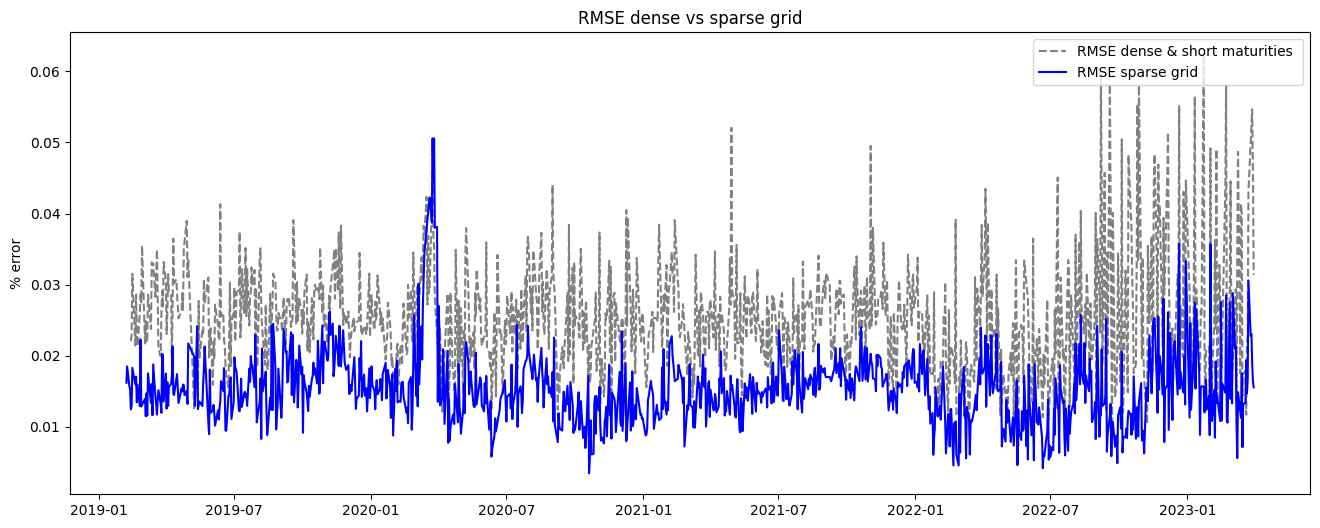

In [133]:
#plot df and df1 rmse
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['rmse'], color='grey', label='RMSE dense & short maturities ', linestyle='dashed')
plt.plot(df1['date'], df1['rmse'], color='blue', label='RMSE sparse grid')
plt.ylabel('% error')
plt.legend(loc='upper right')
plt.title('RMSE dense vs sparse grid')
plt.show()



<b>Visualization of Error Heatmap dense grid</b>

In [30]:
alldays = pd.DataFrame()

In [42]:
#store the results in a df
year = 2023
for i in range(1,4):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

  
        

    for zz in range(len):

        df2 = df1[zz]
            

        dates, percent = helpers.init()
        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]
      

        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 368


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.linspace(0.01,1,6)
        short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.05)*0.05,short_end))
        #
        strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.03)*0.03
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))

        #convert volmatrix back to df with 3 cols
        #datf = volmatrix.stack().reset_index()
        #mame cols
        #datf.columns = ['Strike', 'Time to Maturity', 'iv']

        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()

        b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)


        try:
            del b[0.0]
        except:
            pass

        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']
        datf['date'] = date

        alldays = alldays.append(datf)



In [41]:
alldays.to_csv("alldaysconcat.csv", index=False)

In [452]:
allresults['date']

0    2019-01-02
1    2019-01-03
2    2019-01-04
3    2019-01-07
4    2019-01-08
        ...    
18   2023-03-27
19   2023-03-28
20   2023-03-29
21   2023-03-30
22   2023-03-31
Name: date, Length: 1118, dtype: datetime64[ns]

In [453]:
alldays['date'] = pd.to_datetime(alldays['date'])
merged_df = alldays.merge(allresults, on='date', how='left')

In [66]:
#save mergeddf to csv
merged_df.to_csv("rbergomiconcatenatedresultsforerror.csv", index=False)
merged_df.head()

NameError: name 'merged_df' is not defined

In [67]:
#or load from external file
merged_df = pd.read_csv("rbergomiconcatenatedresultsforerror.csv")

In [68]:
predicting = pd.DataFrame()
predicting['Moneyness'] = merged_df['Moneyness']
predicting['Time to Maturity (years)'] = merged_df['Time to Maturity']
predicting['H'] = merged_df['H']
predicting['eta'] = merged_df['eta']
predicting['rho'] = merged_df['rho']
predicting['v0'] = merged_df['v0']
scaled = SCALER.transform(predicting)
predicting['predicted_iv'] = model.predict(scaled)
predicting['absolute_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])
predicting['relative_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])/merged_df['iv']

8754/8754 [==============================] - 19s 2ms/step


In [69]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='absolute_error', aggfunc='mean').stack().reset_index()

In [70]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'absolute_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

Moneyness  Time to Maturity (years)  absolute_error  Log Moneyness
0       0.84                      0.01        0.109074      -0.174353
1       0.84                      0.02        0.107223      -0.174353
2       0.84                      0.03        0.089432      -0.174353
3       0.84                      0.04        0.067494      -0.174353
4       0.84                      0.05        0.046186      -0.174353

In [71]:
min_error = np.min(flatteneddf['absolute_error'])
max_error = np.max(flatteneddf['absolute_error'])

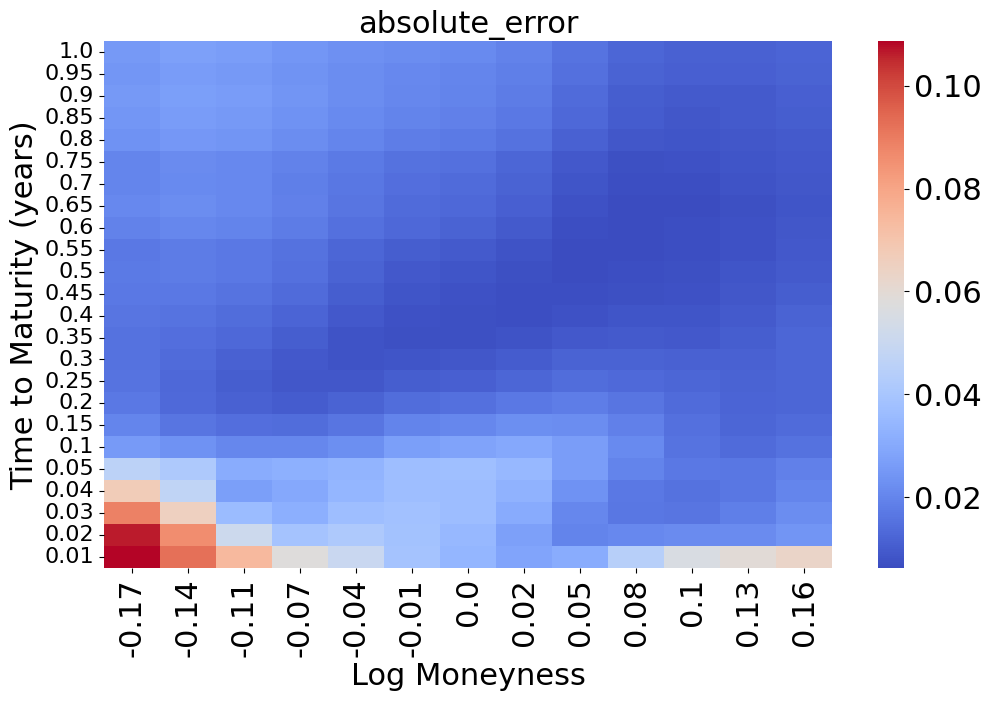

In [458]:
plot_heatmap(flatteneddf, 'absolute_error')

In [436]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='relative_error', aggfunc='mean').stack().reset_index()

In [445]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'relative_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

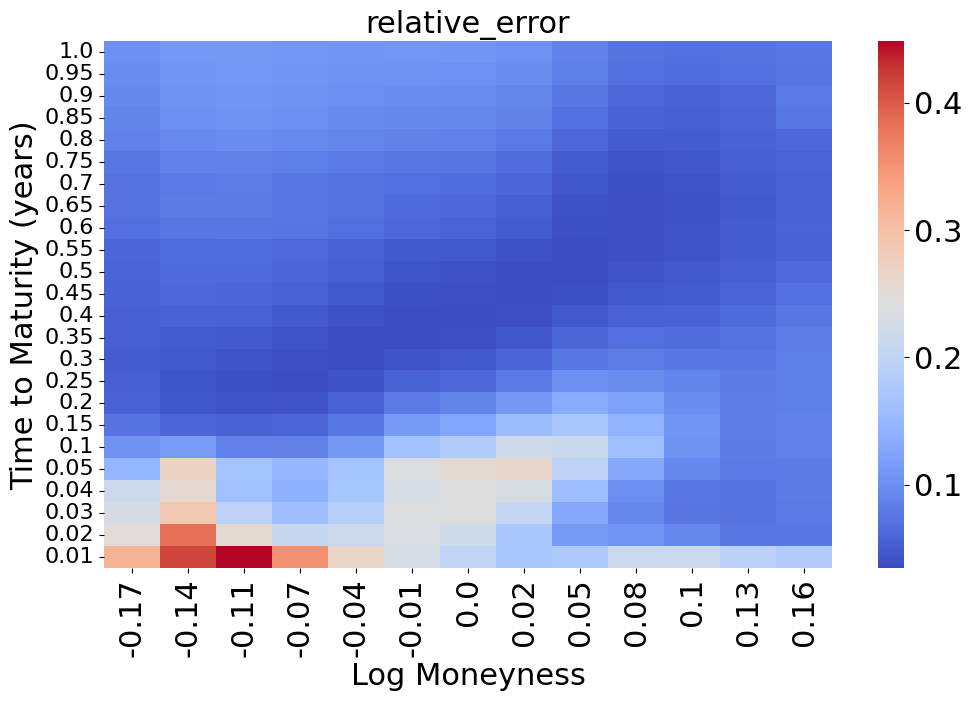

In [438]:
plot_heatmap(flatteneddf, 'relative_error')

<b>Visualization of Error Heatmap less dense grid</b>

In [65]:
alldays = pd.DataFrame()

In [91]:
#store the results in a df
year = 2019
for i in range(1,13):
    month = i
    df1 = helpers.load_month(year, month,'SPX')
    df1,len = helpers.split_days(df1, num_groups = 1)

  
        

    for zz in range(len):

        df2 = df1[zz]
            

        dates, percent = helpers.init()
        #only use traded quotes, this is already done in the pre-processing and just to be sure no illiquid quotes are left over
        #df = df[df[' [C_VOLUME]'] > 0]
        df2 = df2[df2[' [C_VOLUME]'] != " "]
        df2 = df2[df2[' [C_VOLUME]'] != ""]
      

        daysaddasint = np.array(helpers.get_daystomaturity(df2)).astype(int)
        strikes = np.array(helpers.get_strike(df2))
        implied_vols = np.array(helpers.get_IV_C(df2))
        year, month, day = helpers.get_pricingdate(df2)
        #convert to date
        date = datetime.date(year, month, day)

        spot = helpers.get_underlyinglast(df2)
            
        mean_vola = np.mean(implied_vols)

        down = 0.835
        up = 1.169

        filter1 = strikes > down*spot
        filter2 = strikes < up*spot
        filter3 = daysaddasint > 0
        filter4 = daysaddasint <= 368


        filter = filter1 & filter2 & filter3 & filter4

        implied_vols = implied_vols[filter].flatten()
        strikes = strikes[filter].flatten()/spot
        daysaddasint = daysaddasint[filter].astype(int).flatten()/365.0



        #add some buckets to the grid which we will use later
        adddays = np.linspace(0.5,1,6)
        short_end = np.linspace(0.5,1,4)
        #short_end = np.array([0.01, 0.02, 0.03, 0.04]).flatten()    #they should be contained in the grid
        daysaddasint = np.concatenate((np.round(np.concatenate((daysaddasint, adddays))/0.1)*0.1,short_end))
        #
        #strikesadd = np.round(np.linspace(0.85,1.15,9),2)
        strikesadd = np.repeat(0.85, 9)
        strikes = np.round(np.concatenate((strikes, strikesadd))/0.05)*0.05
        atm = np.array(1.0).flatten()

        strikes = np.concatenate((strikes,atm))#at the money is out of rounding scheme
        #16x np.nan
        nans = np.repeat(np.nan, 10)
        implied_vols = np.concatenate((implied_vols, nans))


        daysaddasint_unique = sorted(np.unique(daysaddasint))

        consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': daysaddasint, 'Implied Volatility': implied_vols})

        #use mean in case of dublicates
        consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


        # Pivot the dataframe to create the matrix
        volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

        #interpolation is used to find outliers, therefore a much denser grid is needed, the interpolated values are not used for calibration
        try:
            volmatrix_interpolation = volmatrix.interpolate(method='quadratic')
        except:
            print("Interpolation failed")
            volmatrix_interpolation = volmatrix.copy()

        volmatrix_interpolation[volmatrix_interpolation < 0] = np.nan

        # outlier detection, one iteration already gives good results 
        # we iterate over smiles and check each smile for outliers
        for i, ds in enumerate(np.array(daysaddasint_unique)):
            first_col = volmatrix_interpolation.iloc[:, i]
            y = first_col.values
            # Smooth the data using a Savitzky-Golay filter
            
            # Calculate the absolute difference between y and y_smooth, more than 2% difference is considered an outlier
            diff = np.abs(y - savgol_filter(y, 6, 1, mode='interp'))> 0.02

            #now we remove the outliers from the original matrix
            #without the interpolation, the outlier detection is not as good
            volmatrix.iloc[diff, i] = np.nan
            volmatrix_interpolation.iloc[diff, i] = np.nan

            
        dates_unique = sorted(np.unique(volmatrix.columns))

        strikes_unique = sorted(volmatrix.index.astype(float))

        #convert volmatrix back to df with 3 cols
        #datf = volmatrix.stack().reset_index()
        #mame cols
        #datf.columns = ['Strike', 'Time to Maturity', 'iv']

        try:
            a = volmatrix.interpolate(method='quadratic', axis=0)
        except:
            print("Interpolation failed")
            a = volmatrix.copy()
        try:    
            b = a.interpolate(method='quadratic', axis=1)
            b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        except:
            print("Interpolation failed")
            b = a.copy()

        b[b < 0.1*mean_vola] = np.nan               #remove some outliers if the interpolation technique fails due to illiquid and isolated quotes (should not be triggered)
        try:
            del b[0.0]
        except:
            pass
        
        datf = b.stack().reset_index()
        datf.columns = ['Moneyness', 'Time to Maturity', 'iv']

        datf['date'] = date

        alldays = alldays.append(datf)



In [80]:
def plot_heatmap(data, values='re'):            #adjusted heatmap to align with color scale of dense grid
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot_table(index='Time to Maturity (years)', columns='Log Moneyness', values=values, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap='coolwarm', cbar=True,
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2),
                     vmin=min_error, vmax=max_error)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.title(values, fontsize=22)
    plt.xlabel('Log Moneyness', fontsize=22)
    plt.ylabel('Time to Maturity (years)', fontsize=22)
    # Adjust x-axis tick labels
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=16, rotation='horizontal')
    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    plt.show()


In [92]:
alldays.to_csv("alldaysconcatlessdense.csv", index=False)

In [465]:
alldays['date'] = pd.to_datetime(alldays['date'])
merged_df = alldays.merge(allresults, on='date', how='left')

In [95]:
#save mergeddf to csv
merged_df.to_csv("rbergomiconcatenatedresultsforerrorLESSDENSE.csv", index=False)
merged_df.head()

Moneyness  Time to Maturity        iv       date         H       eta  \
0       0.85               0.2  0.235394 2023-01-04  0.042333  1.681004   
1       0.85               0.3  0.247216 2023-01-04  0.042333  1.681004   
2       0.85               0.4  0.250217 2023-01-04  0.042333  1.681004   
3       0.85               0.5  0.250683 2023-01-04  0.042333  1.681004   
4       0.85               0.6  0.252790 2023-01-04  0.042333  1.681004   

        rho        v0      rmse       mse       mae  median_se  
0 -0.745138  0.051942  0.011273  0.000127  0.009587   0.000088  
1 -0.745138  0.051942  0.011273  0.000127  0.009587   0.000088  
2 -0.745138  0.051942  0.011273  0.000127  0.009587   0.000088  
3 -0.745138  0.051942  0.011273  0.000127  0.009587   0.000088  
4 -0.745138  0.051942  0.011273  0.000127  0.009587   0.000088

In [73]:
#or load from csv
merged_df = pd.read_csv("rbergomiconcatenatedresultsforerrorLESSDENSE.csv")

In [74]:
predicting = pd.DataFrame()
predicting['Moneyness'] = merged_df['Moneyness']
predicting['Time to Maturity (years)'] = merged_df['Time to Maturity']
predicting['H'] = merged_df['H']
predicting['eta'] = merged_df['eta']
predicting['rho'] = merged_df['rho']
predicting['v0'] = merged_df['v0']
scaled = SCALER.transform(predicting)
predicting['predicted_iv'] = model.predict(scaled)
predicting['absolute_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])
predicting['relative_error'] = np.abs(predicting['predicted_iv'] - merged_df['iv'])/merged_df['iv']

2703/2703 [==============================] - 5s 2ms/step


In [83]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='absolute_error', aggfunc='mean').stack().reset_index()

In [84]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'absolute_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

Moneyness  Time to Maturity (years)  absolute_error  Log Moneyness
0       0.85                       0.1        0.037619      -0.162519
1       0.85                       0.2        0.018106      -0.162519
2       0.85                       0.3        0.011699      -0.162519
3       0.85                       0.4        0.009145      -0.162519
4       0.85                       0.5        0.009399      -0.162519

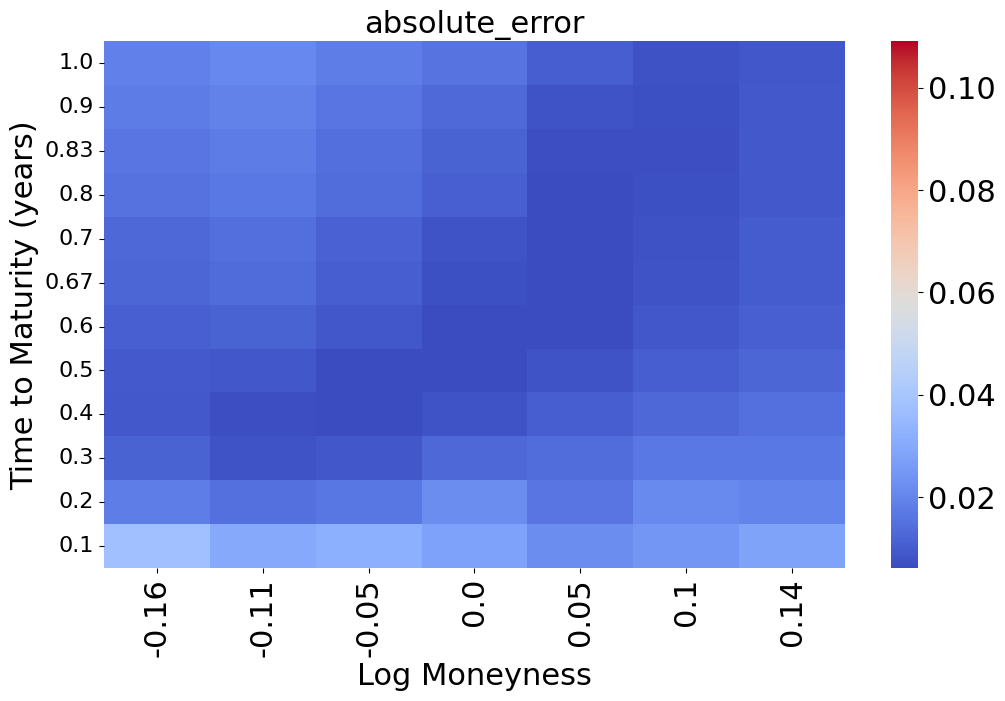

In [82]:
plot_heatmap(flatteneddf, 'absolute_error')

In [474]:
#pivot with rows moneyness cols time to maturity and values rmse aggregated by mean
flatteneddf = predicting.pivot_table(index='Moneyness', columns='Time to Maturity (years)', values='relative_error', aggfunc='mean').stack().reset_index()

In [475]:
#name cols
flatteneddf.columns = ['Moneyness', 'Time to Maturity (years)', 'relative_error']
flatteneddf['Log Moneyness'] = np.log(flatteneddf['Moneyness'])
flatteneddf.head()

Moneyness  Time to Maturity (years)  relative_error  Log Moneyness
0       0.85                       0.1        0.139277      -0.162519
1       0.85                       0.2        0.064150      -0.162519
2       0.85                       0.3        0.041203      -0.162519
3       0.85                       0.4        0.031927      -0.162519
4       0.85                       0.5        0.032290      -0.162519

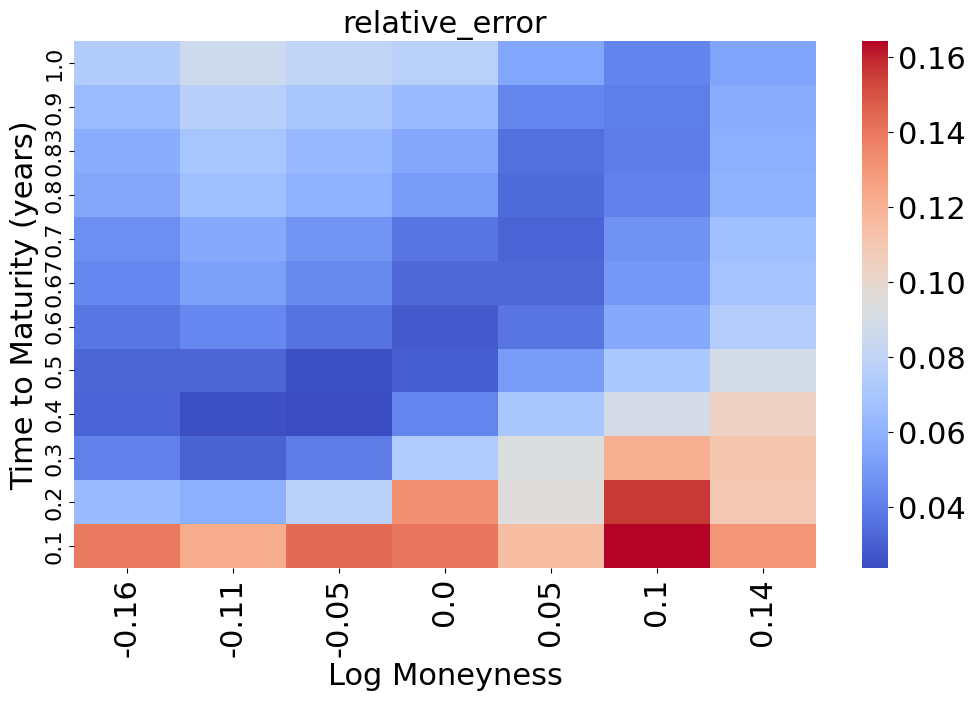

In [478]:
plot_heatmap(flatteneddf, 'relative_error')